<a href="https://colab.research.google.com/github/aimedvedevq/Russian-Handwritting-Recognition/blob/main/HWTR_%D0%B8%D1%82%D0%BE%D0%B3%D0%BE%D0%B2%D1%8B%D0%B9_%D0%BE%D1%82%D1%87%D0%B5%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Распознавание русского рукописного текста**

***Авторы: Александр Медведев, Никита Разуваев, Тюпин Денис ОАИТ ЦА***

# Итоговый отчет

В ходе эксперимента нам удалось решить задачу распознавания рукописного текста, получив $CER = 0.093 $ и $WER = 0.219 $. Задача сегментации рукописного текста (Text-Line Recognition) в нашем эксперементе не решалась, поэтому текущая реализация не готова к полевым испытаниям. Более того, не удалось использовать лингвистическую модель для улучшения результата.

## Данные для обучения

Для обучения использовали 2 набора данных:

Русскоязычную базу:

- [Handwritten Kazakh and Russian (HKR) database for text recognition](https://github.com/abdoelsayed2016/HKR_Dataset) **[Лицензия Non-commercial]**

  ***Достоинства***:
  - Содержит около 63 тысяч изображений предложений (на самом деле слов и словосочетаний), написанных около 200 почерками.
  - Наверное, единственный датасет для задачи распознавания русского рукописного текста.

  ***Недостатки***:
  - Уникальных предложений около 2,8 тысяч. Обучались только на них, чтобы не переобучаться под отдельные фразы. Предполагалось, что модель даже на таком наборе данных обучится воспринимать разные написания одних и тех же символов.
  - "Предложения" слишком короткие, обычно 1-2 слова, что не позволяет модели обучиться распознавать длинные последовательности.
  - Местами плохая разметка

Англоязычную базу:
 
- [IAM Handwriting Database](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database) **[Лицензия Non-commercial]**

  ***Достоинства***:
  - 13,4 тысячи изображений отсегментированных и очищенных предложений. Около 650 разных почерков.
  - Длинные предложения. Много уникальных.

  ***Недостатки***:
  - Неудобная разметка - все токены разделены (например, запятая выделена пробелами с двух сторон), что несоответствует написанию в реальных условиях. Местами есть ошибки.

## Параметры и архитектура модели

Архитектура baseline модели напоминает архитектуру из статьи [Convolve, Attend and Spell](http://www.cvc.uab.es/~marcal/pdfs/GCPR18.pdf) с рядом изменений. Вместо VGG использовали ResNet, а вместо GRU - LSTM, ориентируясь на опыт и код победителей соревнования [Digital Peter](https://github.com/lolpa1n/digital-peter-ocrv), однако для декодинга использовали [LSTM с механизмом внимания](https://openspeech-team.github.io/openspeech/modules/Decoders.html#module-openspeech.decoders.lstm_attention_decoder), реализованную в библиотеке [openspeech](https://github.com/openspeech-team/openspeech). 

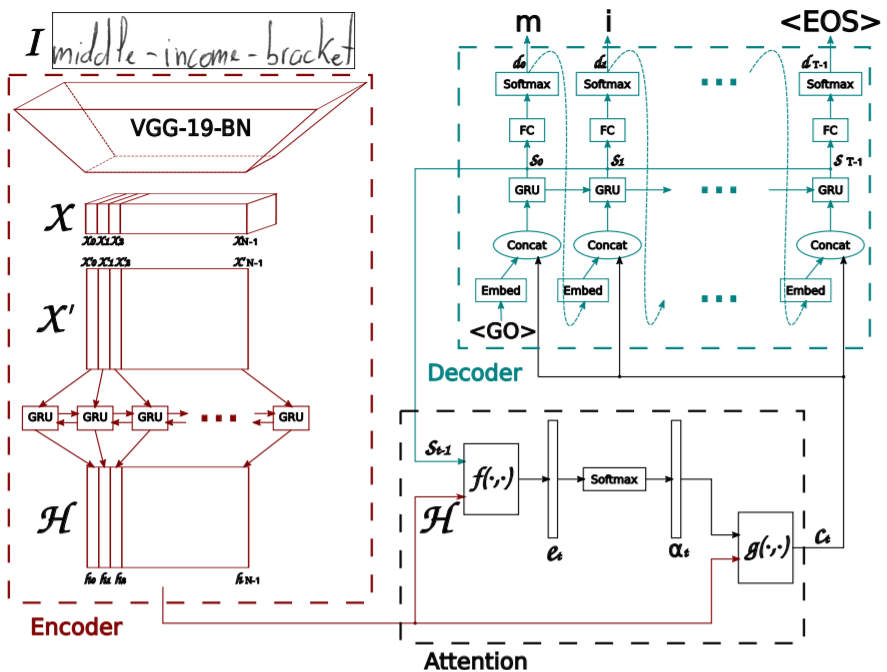

Базовая модель содержит N параметров, веса занимают 72 МБ дискового пространства. Скорость модели составляет примерно 5 картинок в секунду на этапе обучения (с аугментациями) и 10 картинок в секунду на этапе применения. 

К сожалению, в виду ограничений google colab на время работы с gpu не смогли попробовать продвинутые архитектуры, такие как [Conformer](https://openspeech-team.github.io/openspeech/architectures/Conformer.html), [Transformer-Transducer](https://openspeech-team.github.io/openspeech/architectures/Transformer%20Transducer.html) и др., реализованные в библиотеке openspeech.

> Особенности библиотеки ***openspeech***

***Достоинства***:
  - Большое количество готовых архитектур для ASR (Automatic speech recognition), которые также подходят для задачи распознавания рукописного текста

***Недостатки***:
  - Библиотека некорректно устанавливается через pip
  - После сборки библиотеки с github возникают ошибки при использовании модулей.

## Параметры обучения

> Для аугментация использовали библиотеку [albumentations](https://github.com/albumentations-team/albumentations), применяли следующие:

- Гауссовский шум
- Размытие
- Сдвиг (max - 6,25%), масштабирование (max - 5%), поворот (max - 5°)
- Оптические искажения
- CLAHE, изменение яркости/контрастности и hue
- Cutout (erase) - вырезка случайных областей из картинки

> Обучали оптимизатором Adam 18 эпох с lr = 0.0001. Для обучения декодера использовался teacher forcing.

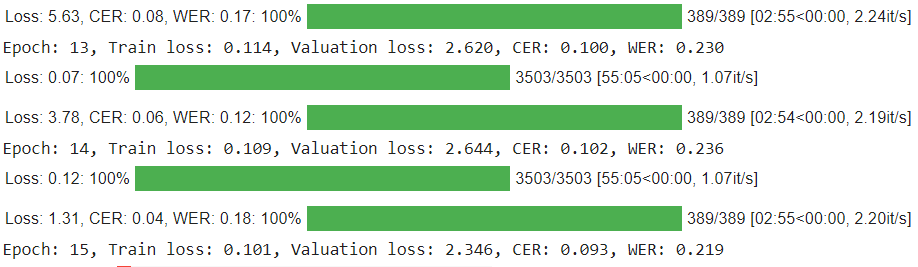

## Инференс

> На этапе применения модели teacher forcing не применяется, dropout выключается и batchnorm замораживается.

> Применили Beam Search, однако результат только ухудшился. Без лингвистической модели BS, вероятно, может не давать положительных результатов.

# Ретроспектива

## Обзор литературы по распознаванию рукописных текстов




### 1. Проблема, описание задачи

> Решение какой проблемы описано в источниках?

Распознавание рукописных текстов (HTR - Handwritten Text Recognition) является важной задачей для автоматизации целого ряда задач. В данном обзоре мы сосредоточимся на распознавании рукописных текстов на изображениях без определения его положения в документе (TLR - Text-Line Recognition).

---

![0_9_623.jpg](https://raw.githubusercontent.com/abdoelsayed2016/HKR_Dataset/master/images/0_9_623.jpg)

> Пример изображения из [HKR database](https://github.com/abdoelsayed2016/HKR_Dataset)

---

Следовательно наша задача состоит в том, чтобы преобразовать картинку с рукописным текстом в ее расшифровку.

Для решения данной задачи будут рассмотрены подходы с использованием нейронных сетей: CNN для извлечения признаков из изображений, RNN (LSTM, GRU, Trancducer-RNN), Transformer, Attention, CTC для раскодирования признаков в результирующую последовательность, а также пост-обработка текста с помощью лингвистических моделей (LM) и Beam Search для улучшения результатов. 

Основные метрики, по которым будет оцениваться качество моделей:

> CER (Character Error Rate):  $CER = \frac{S + D + I}{N}$

> WER (Word Error Rate): $WER = \frac{S_w + D_w + I_w}{N_w}$

где $S$ - замены символов ($S_w$ - слов), $D$ - удаления символов, $I$ - втавки символов, $N$ - общее количество символов

> SER (Sentence Error Rate) = $SER = \frac{Кол-во \space предложений \space с \space ошибками}{Кол-во \space всех \space предложений}$

### 2. Резюме источников

> Описать своими словами краткое содержание

Распознавание рукописного текста и определение текста на картинке обычно рассматриваются отдельно в задачах TLR, и большая часть работ в литературе посвящена одному или другому. Тем не менее, предложенные модели имеют много общего. Обычно они основаны на CNN (сверточных нейронных сетях) для извлечения последовательности признаков изображенрия, которые впоследствии передаются кодировщику или декодировщику для расшифровки последовательности символов. 



Описание статей:

  - [Handwritten Digit Recognition using Machine and Deep Learning Algorithms](https://arxiv.org/abs/2106.12614) 
  
  Распознавание рукописного ввода (HWR), также известное как распознавание рукописного текста (HTR), - это способность компьютера получать и интерпретировать понятный рукописный ввод из таких источников, как бумажные документы, фотографии, сенсорные экраны и другие устройства. В статье исследуется распознавание рукописных цифр с помощью набора данных MNIST с использованием метода опорных векторов (SVM), многослойного персептрона (MLP) и сверточной нейронной сети (CNN). Основная цель - сравнить точность указанных выше моделей и время их выполнения, чтобы получить наилучшую возможную модель для распознавания цифр.

  - [Classification of Handwritten Names of Cities and Handwritten Text Recognition using Various Deep Learning Models](https://arxiv.org/abs/2102.04816) 

  Первая модель использует сверточные нейронные сети (CNN) для извлечения признаков и полносвязную нейронную сеть (MLP) для классификации слов. Вторая модель, получившая название SimpleHTR, использует сверточные слои (CNN) и рекуррентные нейронные сети (RNN) для извлечения информации из изображений. Так же предлагаются модели Bluechet и Puchserver для сравнения результатов. В связи с отсутствием доступных открытых наборов данных на русском и казахском языках, авторами статьи проведена работа по сбору данных, которые включают рукописные названия стран и городов из 42 различных кириллических слов, написанные более 500 разными почерками. В результате была собрана база рукописных текстов на казахском и русском языках (HKR).

  - [MuLTReNets: Multilingual text recognition networks for simultaneous script identification and handwriting recognition](https://www.sciencedirect.com/science/article/abs/pii/S0031320320303587)

  В статье предлагается новая архитектура, для многоязычного распознавания рукописного текста и его категоризации (MuLTReNets). В частности, система состоит из четырех основных модулей: экстрактора признаков, идентификатора текста, распознавателя почерка и автоматического взвешивания. Экстрактор признаков объединяет пространственные и временные данные для кодирования текстовых изображений в признаки, общие для идентификатора текста и распознавателя почерка. Идентификатор текста предсказывает категорию (например, язык, на котором написан текст) из последовательности переменной длины, используя автоматические весовые коэффициенты, в то время как распознаватель рукописного ввода использует модули LSTM и CTC для выполнения декодирования последовательности. Благодаря многозадачному обучению исследуемая архитектура может быть эффективной в двух схемах распознавания: многоязычном распознавании с объединенным алфавитом (MuLTReNetV1) и распознавании текста с идентификацией языка, используя совместное обучение (MuLTReNetV2).
  
- [Lei Kang, J.Ignacio Toledo, Pau Riba, Mauricio Villegas, Alicia Forn´es, Mar¸cal Rusi˜nol, 2021](http://www.cvc.uab.es/~marcal/pdfs/GCPR18.pdf) 

  Предлагается Convolve, Attend and Spell - attention-based  sequence-to-sequence модель для распознавания рукописных слов. Исследуемая архитектура состоит из трех основных частей: кодировщика, состоящего из CNN и двунаправленного GRU, attention, и декодера, из однонаправленного GRU, для спеллинга слов. По сравнению с последними достижениями, наша модель позволяет достичь конкурентоспособных результатов в наборе данных IAM без необходимости предварительной обработки, предопределенного словаря или языковой модели. К данной статье доступен код. Авторы превзошли большинство современных методов и добились частоты ошибок на символов 6,88% и частоты ошибок слов 17,45% в наборе данных IAM.

- [Abdelrahman Abdallah, Daniyar Nurseitov, Mohamed Ahmed Hamada, 2020](https://www.researchgate.net/publication/347845048_Attention-Based_Fully_Gated_CNN-BGRU_for_Russian_Handwritten_Text) 

  В статье рассматривается задача распознавания рукописного текста с использованием attention-based encoder-decoder нейронных стей, обученных на казахском и русском языках. Авторы разработали новую модель глубокой нейронной сети, основанную на полностью стробированной CNN, поддерживаемой множеством двунаправленных стробируемых рекуррентных блоков (BGRU) и механизмами attention для управления сложными функциями, которые достигают 0,045 Caracter Error Rate (CER), 0,192 Word Error Rate (WER). и 0,253 Sequence Error Rate (SER) на рассматриваемом наборе данных.Эффективность предложенного метода оценивалась с использованием баз данных рукописных текстов на трех языках: английском, русском и казахском. Он демонстрирует лучшие результаты на наборе данных Рукописного казахского и русского языков (HKR), чем другие известные модели.

### 3. **Сравнение**

> В чем похожа, а в чем различна информация в источниках? Как информация в источниках согласуется между собой?

Стандартный пайплайн моделей для распознавания рукописных текстов на изображении включает в себя несколько этапов:

1. Backbone - нейронная сеть, извлекающая признаки из изображения. Часто используются архитектуры ResNet, Inception, MobileNet-like. 

2. Encoder/Decoder признаков изображения, основанный на RNN, CTC или Attention

3. Для улучшения прогнозов модели (рескоринга) при инференсе дополнительно используется лингвистическая модель или Beam Search

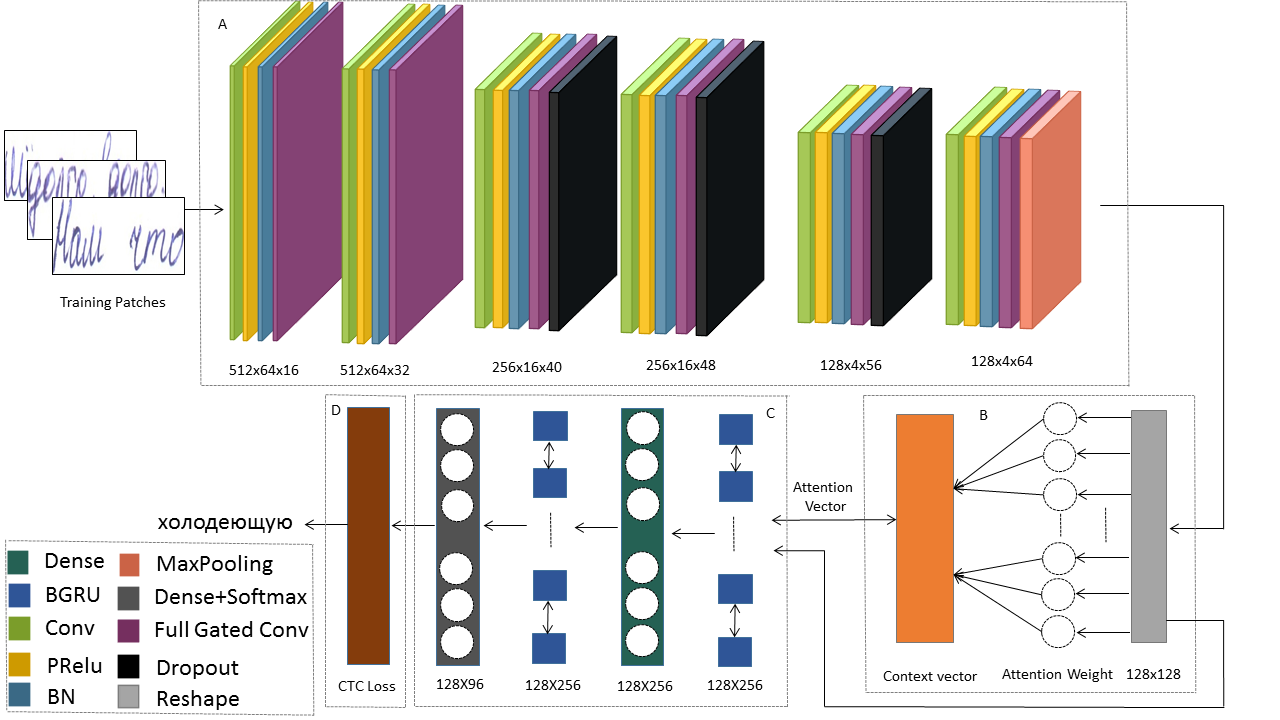

> Пример пайплайна из статьи Attention-Based Fully Gated CNN-BGRU for Russian Handwritten Text

- ***Сравнение архитектур моделей из статьи "Rethinking Text Line Recognition Models"***:

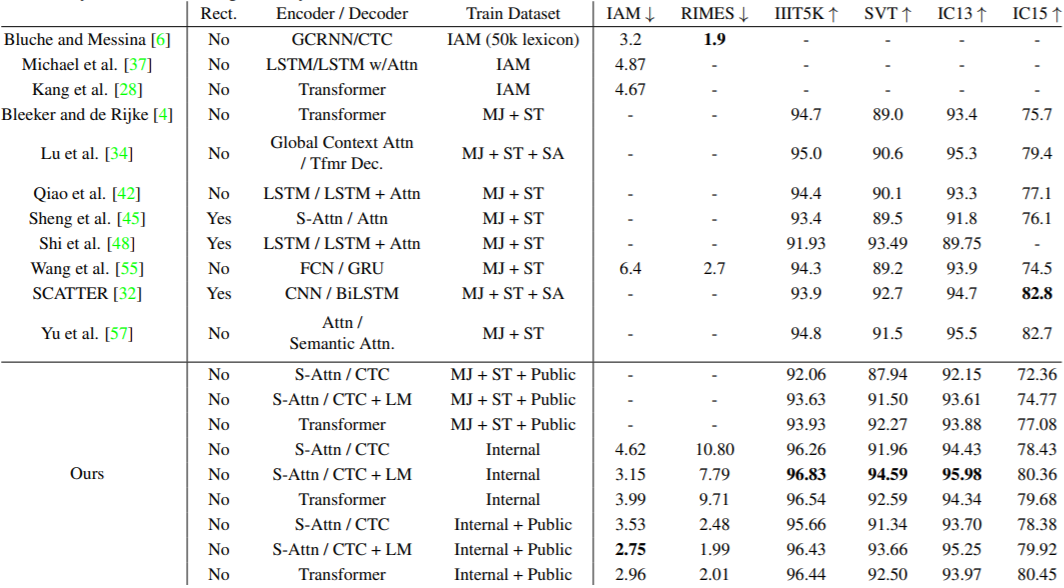

> Результаты оценки моделей на общедоступных наборах данных рукописных текстов. Для IAM и RIMES указаны CER, для остальных - WPA (Word Prediction Accuracy = 1 - WER). "Rect." столбец указывает на то, включает ли модель модуль коррекции ошибок лингвистической моделью. «S-Attn», «Attn» и «Tfmr Dec.» означает SelfAttention, Attention и Transformer Decoder соответственно. «MJ», «ST» и «SA» обозначают [MJSynth](https://www.robots.ox.ac.uk/~vgg/data/text/), [SynthText](https://github.com/ankush-me/SynthText) и [SynthAdd](https://github.com/tensorflow/datasets/blob/master/docs/add_dataset.md) соответственно (инструменты для создания картинок с размеченным текстом).



### 4. Перспективы

> Как можно продолжить исследования, описанные в источниках? Какие открытые вопросы существуют?

- В статьях много внимания уделяется распознаванию обработанных картинок с текстом (как в примере из секции 1), а исследований в области end-to-end распознавания рукописного текста в документах существенно меньше. 

- Недостаточно размеченных открытых данных для обучения моделей.

 Для английского языка, как правило, упоминается 3 датасета - IAM (100 тыс. изображений слов, 651 автор), CVL (80 тыс. изображений слов, 310 авторов) и RIMES (60 тыс. изображений, 1300 авторов), в то время как для русского языка открытый датасет (HKR: 63 тыс. предложений, 200 авторов) появился около года назад, а других найти не удалось.

### 5. Список литературы

> По алфавиту, список полных имен авторов, год публикации, заголовок, источник (журнал, конференция, сайт, ...), ссылка

1. Abdallah A., Hamada M., Nurseitov D. Attention-based Fully Gated CNN-BGRU for Russian Handwritten Text //Journal of Imaging. – 2020. – Т. 6. – №. 12. – С. 141.

2. Nurseitov D. et al. Classification of Handwritten Names of Cities and Handwritten Text Recognition using Various Deep Learning Models //arXiv preprint arXiv:2102.04816. – 2021.

3. Kang L. et al. Convolve, attend and spell: An attention-based sequence-to-sequence model for handwritten word recognition //German Conference on Pattern Recognition. – Springer, Cham, 2018. – С. 459-472.

4. Pashine S., Dixit R., Kushwah R. Handwritten Digit Recognition using Machine and Deep Learning Algorithms //arXiv preprint arXiv:2106.12614. – 2021.

5. Chen Z. et al. MuLTReNets: Multilingual text recognition networks for simultaneous script identification and handwriting recognition //Pattern Recognition. – 2020. – Т. 108. – С. 107555.

6. Diaz D. H. et al. Rethinking Text Line Recognition Models //arXiv preprint arXiv:2104.07787. – 2021.

#### Полезные ссылки

##### Интернет ресурсы
- Материалы по DL в обработке звука (задача у нас похожая - только на входе не звук, а картина):
  - [Lecture: Metrics, Attention, LAS, CTC, BeamSearch](https://github.com/markovka17/dla/blob/master/week02)
  - [Lecture: LM Fusing, RNN Transducer, Schedule Sampling, BPE](https://github.com/markovka17/dla/blob/master/week03)

- Digital Peter: recognition of Peter the Great's manuscripts:
  - ArXiv: http://arxiv.org/abs/2103.09354
  - Git: https://github.com/sberbank-ai/digital_peter_aij2020#digital-peter-recognition-of-peter-the-greats-manuscripts
  - Habr: [Первое место на AI Journey 2020 Digital Петр](https://habr.com/ru/post/535224/); Git: https://github.com/lolpa1n/digital-peter-ocrv

- В статейке описаны методы и прочее: [How to easily do Handwriting Recognition using Deep Learning](https://nanonets.com/blog/handwritten-character-recognition/)

- Статья про CTC-loss в задаче распознования рукописного текста: [Handwriting to Text Conversion using Time Distributed CNN and LSTM with CTC Loss Function](https://towardsdatascience.com/handwriting-to-text-conversion-using-time-distributed-cnn-and-lstm-with-ctc-loss-function-a784dccc8ec3)

##### Статьи:
  - [Convolve, Attend and Spell: An Attention-based Sequence-to-Sequence
Model for Handwritten Word Recognition](http://www.cvc.uab.es/~marcal/pdfs/GCPR18.pdf)
  - [TextAdaIN: Fine-Grained AdaIN for Robust Text Recognition](https://arxiv.org/abs/2105.03906)
  - [Rethinking Text Line Recognition Models](https://arxiv.org/abs/2104.07787)
  - [Attention-Based Fully Gated CNN-BGRU for Russian Handwritten Text](https://www.researchgate.net/publication/347845048_Attention-Based_Fully_Gated_CNN-BGRU_for_Russian_Handwritten_Text); [arXiv](https://arxiv.org/pdf/2008.05373.pdf)
    - Статья с использованием русского датасета
  - [Recurrent neural network transducer for Japanese and Chinese offline handwritten text recognition](https://arxiv.org/abs/2106.14459)
  - [Arabic handwriting recognition system using convolutional neural network](https://link.springer.com/article/10.1007/s00521-020-05070-8)
  - [Handwritten Digit Recognition using Machine and Deep Learning Algorithms](https://arxiv.org/abs/2106.12614)
  - [Classification of Handwritten Names of Cities and Handwritten Text Recognition using Various Deep Learning Models](https://arxiv.org/abs/2102.04816)
  - [MuLTReNets: Multilingual text recognition networks for simultaneous script identification and handwriting recognition](https://www.sciencedirect.com/science/article/abs/pii/S0031320320303587)

##### Источники данных:
  
  - Англоязычные ресурсы:
    - [IAM Handwriting Database](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database) **[Non-commercial. ДОСТУПНО]**
    - [CVL: An Off-line Database for Writer Retrieval, Writer Identification and Word Spotting](https://cvl.tuwien.ac.at/research/cvl-databases/an-off-line-database-for-writer-retrieval-writer-identification-and-word-spotting/) **[Non-commercial. ДОСТУПНО]**
    - [The RIMES database](http://www.a2ialab.com/doku.php?id=rimes_database:start) **[Non-commercial. ТРЕБУЕТСЯ ОТПРАВИТЬ ФОРМУ]**
  
  - Рускоязычные ресурсы:
    - [Handwritten Kazakh and Russian (HKR) database for text recognition](https://github.com/abdoelsayed2016/HKR_Dataset) **[Non-commercial. ТРЕБУЕТСЯ СОГЛАСОВАНИЕ]**


    

## Протокол эксперимента

### 1. **Гипотезы**

Распознавание рукописного текста является открытой задачей в науке. Ввиду недостатка открытых наборов данных для русского языка обучение модели и ее итоговые показатели могут оказаться невысокими. 

В ходе эксперимента будут рассмотрены различные архитектуры моделей и их показатели, а также выбрана наилучшая. Для улучшения итоговых метрик модели потребуется обучать совместно и на русском и на английском языке, а также использовать аугументации для регуляризации и расширения обучающей выборки.

В результате эксперимента необходимо получить воспроизводимый код для обучения и валидации модели. Получение метрик, сопоставимых с упоминаемыми в научной литературе, будет означать успешное завершение эксперимента.

### 2. Данные

В качестве данных для обучения моделей будут использоваться следующие открытые источники:

- Рускоязычные ресурсы:
  - [Cyrillic Handwriting Dataset](https://www.kaggle.com/constantinwerner/cyrillic-handwriting-dataset) **[CC0]**
  - [Handwritten Kazakh and Russian (HKR) database for text recognition](https://github.com/abdoelsayed2016/HKR_Dataset) **[Non-commercial. При наличии согласования с авторами]**
  
- Англоязычные ресурсы:
  - [IAM Handwriting Database](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database) **[Non-commercial. ДОСТУПНО]**
  - [CVL: An Off-line Database for Writer Retrieval, Writer Identification and Word Spotting](https://cvl.tuwien.ac.at/research/cvl-databases/an-off-line-database-for-writer-retrieval-writer-identification-and-word-spotting/) **[Non-commercial. ДОСТУПНО]**
  - [The RIMES database](http://www.a2ialab.com/doku.php?id=rimes_database:start) **[Non-commercial. При наличии согласования с авторами]**

### 3. Метрики

Основные метрики, по которым будет оцениваться качество моделей:

> CER (Character Error Rate):  $CER = \frac{S + D + I}{N}$

> WER (Word Error Rate): $WER = \frac{S_w + D_w + I_w}{N_w}$ или WPA (Word Prediction Accuracy): $WPA = 1 - WER$

где $S$ - замены символов ($S_w$ - слов), $D$ - удаления символов, $I$ - втавки символов, $N$ - общее количество символов

> SER (Sentence Error Rate) = $SER = \frac{Кол-во \space предложений \space с \space ошибками}{Кол-во \space всех \space предложений}$

Кроме того, в качестве метрик предполагается использование значение ошибки модели (loss) для оценки качества ее обучения.

### 4. Модели

В качестве baseline модели предполагается рассмотреть Attention-Gated-CNN-BGRU из статьи [Abdallah A., Hamada M., Nurseitov D.], а также исследовать возможности ее улучшения, путем использования Transformer или LSTM-блоков. 

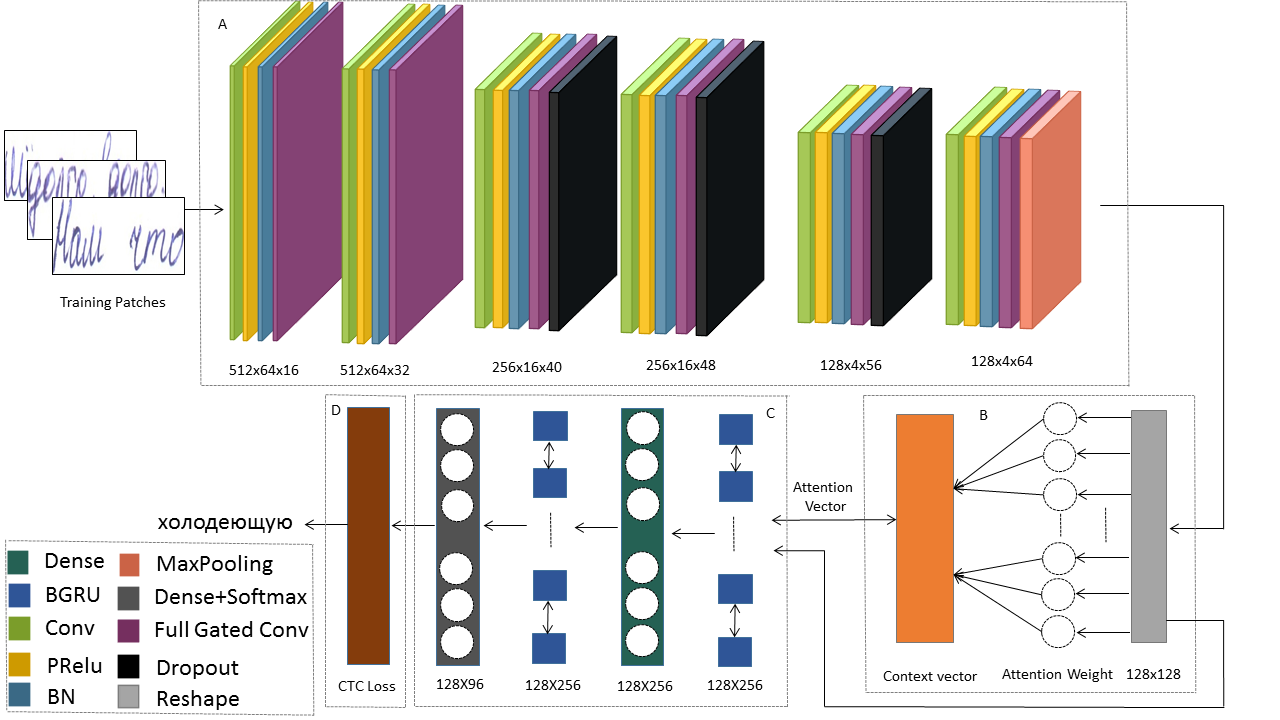

> На рисунке изображена схема модели Attention-Gated-CNN-BGRU для распознавания рукописного текста. Модель состоит из 4-х частей: (A) энкодер (CNN), (B) attention-блок, (C) декодер и CTC (D). Входное изображение преобразуется энкодером в вектора признаков. Attention-блок позволяет модели фокусироваться на важных частях изображения и формирует контекстный вектор для декодера. Декодер обрабатывает последовательность признаков для предсказания последовательности символов. CTC выходного слоя используется для раскодирования и подсчета ошибки.

Перспективным направлением исследования является реализация актуальных архитектур моделей [Conformer](https://arxiv.org/abs/2005.08100) и [RNN Transducer](https://www.microsoft.com/en-us/research/uploads/prod/2019/10/RNNT.pdf) предложенных в статьях [Gulati A. et al.] и [Li J. et al.]. Conformer использует transformer-подобную архитектуру аугументированную сверточными блоками, в то время как RNN Transducer предназначен для раскодирования последовательности и может заменить CTC Loss, поскольку учитывает информацию результирующей последовательности, в отличии от CTC. 

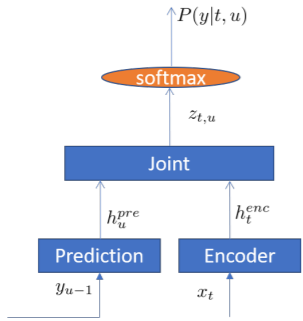

> Схема RNN-Transducer

### 5. Как данные и модели используются для гипотезы

В ходе эксперимента предполагается обучение модели на русских и английских наборах данных. См. п. 2 и п. 4 протокола.

### 6. Содержание проекта

> Что нужно сделать; что может помешать проекту?

В ключевые *задачи* проекта входит:

1. Сбор данных для обучения из открытых источников

2. Изучение научной литературы, релевантной для решения задачи

3. Проработка архитектуры модели, реализация воспроизводимого пайплайна обучения и валидации моделей

4. Оценка качества работы и метрик моделей

5. Отчет о проделанной работе

Среди потенциальных *препятствий* реализации проекта можно выделить:

1. Отсутствие достаточного количества данных на русском языке для обучения модели распознавания русского рукописного текста

2. Смещение обучающей выборки относительно данных реальных задач, в результате чего, модель может оказаться неприменимой.

3. Отсутствие необходимых компетенций команды для создания сложных алгоритмов, описанных в научных статьях. 

### Список источников

> По алфавиту, список полных имен авторов, год публикации, заголовок, источник (журнал, конференция, сайт, ...), ссылка

1. Abdallah A., Hamada M., Nurseitov D. [Attention-based Fully Gated CNN-BGRU for Russian Handwritten Text](https://www.researchgate.net/publication/347845048_Attention-Based_Fully_Gated_CNN-BGRU_for_Russian_Handwritten_Text) //Journal of Imaging. – 2020. – Т. 6. – №. 12. – С. 141.

2. Gulati A. et al. [Conformer: Convolution-augmented transformer for speech recognition](https://arxiv.org/abs/2005.08100) //arXiv preprint arXiv:2005.08100. – 2020.

3. Kleber F. et al. [Cvl-database: An off-line database for writer retrieval, writer identification and word spotting //2013 12th international conference on document analysis and recognition.](https://cvl.tuwien.ac.at/research/cvl-databases/an-off-line-database-for-writer-retrieval-writer-identification-and-word-spotting/) – IEEE, 2013. – С. 560-564.

4. Nurseitov D. et al. [Handwritten Kazakh and Russian (HKR) database for text recognition](https://arxiv.org/pdf/2007.03579.pdf) //Multimedia Tools and Applications. – 2021. – С. 1-23.

5. Marti U. V., Bunke H. [The IAM-database: an English sentence database for offline handwriting recognition](https://www.researchgate.net/publication/226662568_The_IAM-database_An_English_sentence_database_for_offline_handwriting_recognition) //International Journal on Document Analysis and Recognition. – 2002. – Т. 5. – №. 1. – С. 39-46.

6. Li J. et al. [Improving RNN transducer modeling for end-to-end speech recognition](https://www.microsoft.com/en-us/research/uploads/prod/2019/10/RNNT.pdf) //2019 IEEE Automatic Speech Recognition and Understanding Workshop (ASRU). – IEEE, 2019. – С. 114-121.

# Обучение модели

## Загрузка данных и библиотек

**Links**:

- https://openspeech-team.github.io/openspeech/index.html

> Задачи для улучшения модели:
- Использовать beamsearch/LM для раскодирования
- Реализовать аугментации для обучения (albumentations)
- Попробовать другие архитектуры (Conformer)
- BPE токенайзер
- Качественнее разбить train и val (учитывая баланс классов)

In [ ]:
#@markdown Клонируем openspeech репо
#@markdown - https://github.com/openspeech-team/openspeech
# Установка пререквизитов
print('Установка...')
!pip install -q pybind11
!pip install -q warp-rnnt
!pip install -q --upgrade albumentations
# Клонируем репо
!git clone https://github.com/openspeech-team/openspeech.git &> /dev/null
%cd openspeech
# Устанавливаем. Через pip не устанавливается нормально :(
!chmod +x ./install.sh
!./install.sh &> /dev/null
%cd ..
# Добавляем в path, где python ищет модули
import sys
sys.path.append('/content/openspeech')

Установка...
     |████████████████████████████████| 200 kB 5.5 MB/s 
     |████████████████████████████████| 98 kB 3.8 MB/s 
     |████████████████████████████████| 37.1 MB 49 kB/s 
/content/openspeech
/content


In [ ]:
import json
import os 
import glob
import pandas as pd


#@markdown Скачиваем HKR Dataset и IAM Handwriting Database
#@markdown - HKR Dataset: https://github.com/abdoelsayed2016/HKR_Dataset
include_hkr = True #@param {type:"boolean"}
if include_hkr:
    # Download HKR Dataset https://github.com/abdoelsayed2016/HKR_Dataset
    # !gdown https://drive.google.com/uc?id=18Z8VzOvtKWL0kWuwiRqAm8ooK0Kx3Tc9
    # Words data:
    !gdown https://drive.google.com/uc?id=1NYbDwnL1SkCOwhDJhcqnOR1pwVFzRF51
    # P@ssw0rd_HKR2020
    # !unrar x -id[q] -pP@ssw0rd_HKR2020 -Y 'HKR_Dataset_Forms_Public.rar'
    # P@ssw0rd-HKR2020
    print('Разархивирование...')
    !unrar x -id[q] -pP@ssw0rd-HKR2020 -Y 'HKR_Dataset_Words_Public.rar'

    # Разметка HKR Dataset
    path_to_files = os.path.join('./20200923_Dataset_Words_Public/img/', '*')

    info_data = []
    for filepath in glob.glob(path_to_files):
        filename = filepath.split('/')[-1]
        filename = filename.split('.')[0]
        with open(filepath.replace('img', 'ann').replace('jpg', 'json'), 'r') as f:
            ann = json.load(f)
        inf = {
            'id': filename,
            'filepath': filepath,
            'text': ann['description'],
            'lang': 'ru'
        }
        info_data.append(inf)

    hkr_data = pd.DataFrame(info_data)

#@markdown - IAM Handwriting Database https://fki.tic.heia-fr.ch/databases/iam-handwriting-database
include_iam = True #@param {type:"boolean"}
if include_iam:
    # Download IAM Handwriting Database: https://fki.tic.heia-fr.ch/databases/iam-handwriting-database
    #### Sentences ####
    # !gdown https://drive.google.com/uc?id=1RWFGzkfLCnXSxmD3ISO-Z7o5r7nE4Oqs
    # !rm -r sentences
    # !mkdir sentences
    # !tar -xf "./sentences.tgz" -C "./sentences"
    #### Lines ####
    !gdown https://drive.google.com/uc?id=1rLZ452uGAnZ6llcFZftCRqUqctU45v4w
    !rm -r lines
    !mkdir lines
    !tar -xf "./lines.tgz" -C "./lines"
    #### XML ####
    # !gdown https://drive.google.com/uc?id=12iUjehxIIB9D6tjcaSMp-HL816EYVs0z
    # !rm -r xml
    # !mkdir xml
    # !tar -xf "./xml.tgz" -C "./xml" 
    #### Ascii ####
    !gdown https://drive.google.com/uc?id=1KOQvaROXNIbk7YoxFoWpVezm-BeZld9z
    !rm -r ascii
    !mkdir ascii
    !tar -xf "./ascii.tgz" -C "./ascii" 

    # Разметка IAM Dataset
    info_list = []
    with open('./ascii/lines.txt', 'r') as f:
        for line in f:
            if line[0] == '#':
                continue
            l = line.split()
            filename, text = l[0], l[-1].replace('|', ' ')
            info_list.append([filename, text])

    path_to_files = os.path.join('./lines/*/*/', '*')
    path_list = []
    for filepath in glob.glob(path_to_files):
        filename = filepath.split('/')[-1]
        filename = filename.split('.')[0]
        path_list.append([filename, filepath, 'eng'])

    info_path = pd.DataFrame(path_list, columns = ['id', 'filepath', 'lang'])
    info_text = pd.DataFrame(info_list, columns = ['id', 'text'])
    iam_data = info_path.merge(info_text, 'left', 'id')
    '''iam_data.text = iam_data.text\
    .str.replace(r'(?<=\w) (?=[,.;:\'\"?])', '')\
    .str.replace('(?<=[\'\"]) (?=[~\w])', '')'''

if include_iam and include_hkr:
    all_data = hkr_data.append(iam_data).reset_index(drop=True)
elif include_iam:
    all_data = iam_data
else:
    all_data = hkr_data

all_data.drop_duplicates('text', keep='last', inplace=True)
all_data.reset_index(drop=True, inplace=True)
print('Num ru:', (all_data.lang == 'ru').sum(), 'Num eng:', (all_data.lang == 'eng').sum())
all_data

Downloading...
From: https://drive.google.com/uc?id=1NYbDwnL1SkCOwhDJhcqnOR1pwVFzRF51
To: /content/HKR_Dataset_Words_Public.rar
757MB [00:08, 84.9MB/s]
Разархивирование...
Downloading...
From: https://drive.google.com/uc?id=1rLZ452uGAnZ6llcFZftCRqUqctU45v4w
To: /content/lines.tgz
668MB [00:06, 108MB/s]
rm: cannot remove 'lines': No such file or directory
Downloading...
From: https://drive.google.com/uc?id=1KOQvaROXNIbk7YoxFoWpVezm-BeZld9z
To: /content/ascii.tgz
2.61MB [00:00, 82.1MB/s]
rm: cannot remove 'ascii': No such file or directory
Num ru: 2808 Num eng: 12760


,id,filepath,text,lang
0,4_37_750,./20200923_Dataset_Words_Public/img/4_37_750.jpg,ни черной,ru
1,8_43_508,./20200923_Dataset_Words_Public/img/8_43_508.jpg,свя,ru
2,5_25_343,./20200923_Dataset_Words_Public/img/5_25_343.jpg,Встают громда,ru
3,10_36_151,./20200923_Dataset_Words_Public/img/10_36_151.jpg,Вост.-Казахстанская,ru
4,13_2_144_,./20200923_Dataset_Words_Public/img/13_2_144_.jpg,Уст-Каменгорск,ru
...,...,...,...,...
15563,m06-098-04,./lines/m06/m06-098/m06-098-04.png,"afternoon of eternity wore on , that long gold...",eng
15564,m06-098-01,./lines/m06/m06-098/m06-098-01.png,back there on a great plan we have . ' ' Go ba...,eng
15565,m06-098-05,./lines/m06/m06-098/m06-098-05.png,of an afternoon that would somewhere lead to,eng
15566,m06-098-06,./lines/m06/m06-098/m06-098-06.png,everlasting night .,eng


In [ ]:
#@markdown Отмасштабировать картинки для ускорения обучения
import cv2
from tqdm.notebook import tqdm
import numpy as np


IMAGE_H = 128 #@param {type:"integer"}
IMAGE_W = 1024 #@param {type:"integer"}

def resize_if_need(img, max_h, max_w):
    img_h, img_w, img_c = img.shape
    coef = 1 if img_h <= max_h and img_w <= max_w else max(img_h / max_h, img_w / max_w)
    h = int(img_h / coef)
    w = int(img_w / coef)
    img = cv2.resize(img, (w, h))
    return img

def make_img_padding_right(image, max_h, max_w):
    img = image.copy()
    img_h, img_w, img_c = img.shape
    bg = np.zeros((max_h, max_w, img_c), dtype=np.uint8)
    x1 = 0  # (max_w - img_w) // 2
    y1 = (max_h - img_h) // 2
    x2 = x1 + img_w
    y2 = y1 + img_h
    bg[y1:y2, x1:x2, :] = img.copy()
    return bg

for imagepath in tqdm(all_data.filepath.values):
    image = cv2.cvtColor(cv2.imread(imagepath), cv2.COLOR_BGR2RGB)
    image = resize_if_need(image, IMAGE_H, IMAGE_W)
    image = make_img_padding_right(image, IMAGE_H, IMAGE_W)
    cv2.imwrite(imagepath, image)

  0%|          | 0/15568 [00:00<?, ?it/s]

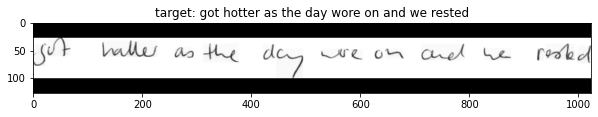

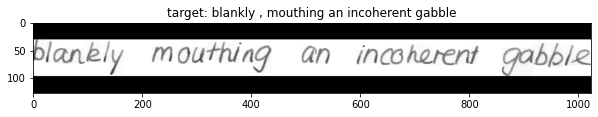

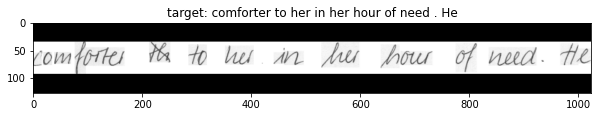

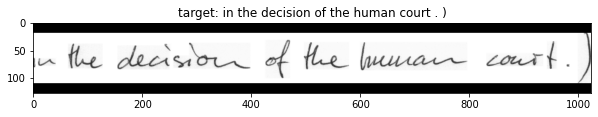

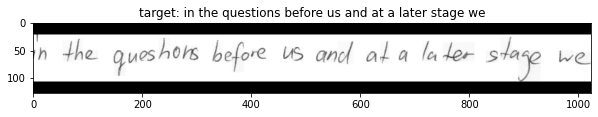

In [ ]:
#@markdown Посмотрим на данные
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

for i in all_data.iloc[np.random.choice(np.arange(len(all_data)), 5)].values:
    img=mpl.image.imread(i[1])
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap ='gray')
    plt.title('target: '+ i[2])

## Создание dataset'a и определение гиперпараметров

In [ ]:
#@markdown Импорт библиотек

import pandas as pd
import numpy as np
import torch
import torchvision
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.models as models
import json
import glob
import math
import cv2
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline

In [ ]:
#@markdown Создание словаря
# VOCAB
BLANK_TOK = '[blk]'
EOS_TOK = '[eos]'
SOS_TOK = '[sos]'
PAD_TOK = '[pad]'

char2int = {}
int2char = {}
VOCAB = set()
for i, k in enumerate(['[pad]', '[sos]', '[eos]', '[blk]']):
    char2int[k] = i
    int2char[i] = k

for i in all_data.text:
    VOCAB.update(list(i))

VOCAB = sorted(list(VOCAB))
for i in range(len(VOCAB)):
    char2int[VOCAB[i]] = i + 4
    int2char[i + 4] = VOCAB[i]

print(''.join(int2char.values()))
pd.DataFrame([int2char]).T.to_csv('vocab.csv')

# Создание конфига для LSTM декодера
from omegaconf import OmegaConf
from openspeech.tokenizers.librispeech.character import LibriSpeechCharacterTokenizer

dictConfig = OmegaConf.create({
    'tokenizer': {
        'pad_token': '[pad]',
        'sos_token': '[sos]',
        'eos_token': '[eos]',
        'blank_token': '[blk]',
        'vocab_path': 'vocab.csv',
        'encoding': 'utf-8'
    }
})

tokenizer = LibriSpeechCharacterTokenizer(dictConfig)

[pad][sos][eos][blk] !"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzАБВГДЕЖЗИЙКЛМНОПРСТУФХЧШЩЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяёғҚқҮӨө–—…


In [ ]:
# Гиперпараметры модели
IMAGE_H, IMAGE_W = 128, 1024
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
VAL_SIZE = 0.1
BATCH_SIZE = 4
OCR_MODEL_PARAMS = {
    'time_feature_count': 256,
    'lstm_hidden': 256,
    'lstm_len': 3,
    'n_class': len(char2int),
    'pad_id': tokenizer.pad_id,
    'sos_id': tokenizer.sos_id,
    'eos_id': tokenizer.eos_id,
}

In [ ]:
#@markdown Создание датасета
class HWTRDataset(Dataset):
    def __init__(self, info_data, tokenizer):
        self.images = []
        self.annotations = []
        self.tokenizer = tokenizer
        for id, image_fname, text, lang in info_data.values:
            self.images.append(image_fname)
            tokens = list(map(int, tokenizer.encode(text).split(' ')))
            tokens = [self.tokenizer.sos_id] + tokens + [self.tokenizer.eos_id]
            self.annotations.append(tokens)

    def __getitem__(self, i):
        image = cv2.cvtColor(cv2.imread(self.images[i]), cv2.COLOR_BGR2RGB)
        tokens = np.array(self.annotations[i], dtype=np.int32)

        return image, tokens

    def __len__(self):
        return len(self.images)

dataset = HWTRDataset(all_data, tokenizer)

In [ ]:
#@markdown Определим аугментации
import albumentations as A

train_transforms = A.Compose([
        # A.RandomRotate90(),
        # A.Flip(),
        # A.Transpose(),
        # A.LongestMaxSize(),
        A.GaussNoise(p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=5, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.2),
            A.GridDistortion(p=.1),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.Cutout(10, 15, 50),
        A.HueSaturationValue(40, 40, 35, p=0.5),
])

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


In [ ]:
#@markdown Разделение на train и val, создание dataloader

from functools import partial

def collate_fn(batch, transforms=None):
    img_batch, tgt_batch, seq_len, tgt_len = [], [], [], []
    for img_sample, tgt_sample in batch:
        if transforms is not None:
            img_sample = transforms(image=img_sample)['image']
        img_sample = img_sample.astype(np.float32) / 255.0
        img_sample = torch.from_numpy(img_sample).permute(2, 0, 1).unsqueeze(0)
        tgt_sample = torch.from_numpy(tgt_sample)
        img_batch.append(img_sample)
        tgt_batch.append(tgt_sample)
        seq_len.append(img_sample.shape[2])
        tgt_len.append(tgt_sample.shape[0])
    
    img_batch = torch.cat(img_batch)
    tgt_batch = pad_sequence(tgt_batch, padding_value=tokenizer.pad_id).T
    seq_len = torch.tensor(seq_len)
    tgt_len = torch.tensor(tgt_len)
    return img_batch, tgt_batch, seq_len, tgt_len

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(VAL_SIZE * dataset_size))
shuffle_dataset = True
if shuffle_dataset:
    np.random.seed(0)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_collate_fn = partial(collate_fn, transforms=train_transforms)
val_collate_fn = partial(collate_fn, transforms=None)

train_dataloader = DataLoader(
    dataset, batch_size=BATCH_SIZE,
    num_workers=2, 
    collate_fn=train_collate_fn, sampler=train_sampler
)
val_dataloader = DataLoader(
    dataset, batch_size=BATCH_SIZE,
    num_workers=2, 
    collate_fn=val_collate_fn, sampler=valid_sampler
)

print('Train size:', len(train_dataloader), '; Val size:', len(val_dataloader), '(batches)')
print('English train size:', (all_data.iloc[indices[split:]].lang == 'eng').sum(),
      '; English val size:', (all_data.iloc[indices[:split]].lang == 'eng').sum())
print('Russian train size:', (all_data.iloc[indices[split:]].lang == 'ru').sum(),
      '; Russian val size:', (all_data.iloc[indices[:split]].lang == 'ru').sum())

Train size: 3503 ; Val size: 389 (batches)
English train size: 11493 ; English val size: 1267
Russian train size: 2519 ; Russian val size: 289


In [ ]:
# Проверка seed: [9046, 9604, 6764, 1103, 2826]
indices[:5]

[9046, 9604, 6764, 1103, 2826]

## Модели

In [ ]:
#@title Baseline model
from openspeech.decoders.lstm_attention_decoder import LSTMAttentionDecoder

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out


class RecognitionModel(nn.Module):
    def __init__(self,
                 feature_extractor,
                 time_feature_count, 
                 lstm_hidden,
                 lstm_len,
                 n_class,
                 pad_id,
                 sos_id,
                 eos_id):
        super(RecognitionModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.avg_pool = nn.AdaptiveAvgPool2d((time_feature_count, time_feature_count))
        self.bilstm = BiLSTM(time_feature_count, lstm_hidden, lstm_len)
        self.decoder = LSTMAttentionDecoder(
            num_classes=n_class, 
            max_length=time_feature_count,
            hidden_state_dim=lstm_hidden * 2,
            pad_id=pad_id, sos_id=sos_id,
            eos_id=eos_id,
            attn_mechanism='multi-head',
            num_heads=4,
            num_layers=2,
            rnn_type='lstm',
            dropout_p=0.3
        )

    def forward(self, x, targets=None, teacher_forcing_ratio=1.0):
        x = self.encode(x)
        x_len = x.shape[1]
        x = self.decoder(x, targets, x_len, teacher_forcing_ratio)
        return x
    
    def encode(self, x):
        x = self.feature_extractor(x)
        b, c, h, w = x.size()
        x = x.view(b, c * h, w)
        x = self.avg_pool(x)
        feat = x.transpose(1, 2)
        x = self.bilstm(feat) # (N, L, D * H)
        return x
    
    def decode(self, x, x_len, targets=None, teacher_forcing_ratio=1.0):
        x = self.decoder(x, targets, x_len, teacher_forcing_ratio)
        return x


def get_resnet_backbone(pretrained=True):
    m = models.resnet34(pretrained=pretrained)
    input_conv = nn.Conv2d(3, 64, 7, 1, 3)
    blocks = [input_conv, m.bn1, m.relu, m.maxpool, m.layer1, m.layer2, m.layer3]
    return nn.Sequential(*blocks)

def get_resnet34_model(pretrained=True):
    backbone = get_resnet_backbone(pretrained)
    model = RecognitionModel(backbone, **OCR_MODEL_PARAMS)
    model = model.to(DEVICE)
    return model


recognition_model = get_resnet34_model(False)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_id)
optimizer = torch.optim.Adam(recognition_model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
# Загрузка весов
!gdown https://drive.google.com/uc?id=1-4VCjPF88Ns_ojGIjQ7FZdChl3cW3Vjq
recognition_model.load_state_dict(torch.load(f'/content/baseline_e{12}.pt'), strict=False)

Downloading...
From: https://drive.google.com/uc?id=1-4VCjPF88Ns_ojGIjQ7FZdChl3cW3Vjq
To: /content/baseline_e12.pt
72.3MB [00:00, 153MB/s]


_IncompatibleKeys(missing_keys=[], unexpected_keys=['beam_search.decoder.embedding.weight', 'beam_search.decoder.rnn.weight_ih_l0', 'beam_search.decoder.rnn.weight_hh_l0', 'beam_search.decoder.rnn.bias_ih_l0', 'beam_search.decoder.rnn.bias_hh_l0', 'beam_search.decoder.rnn.weight_ih_l1', 'beam_search.decoder.rnn.weight_hh_l1', 'beam_search.decoder.rnn.bias_ih_l1', 'beam_search.decoder.rnn.bias_hh_l1', 'beam_search.decoder.attention.query_proj.linear.weight', 'beam_search.decoder.attention.query_proj.linear.bias', 'beam_search.decoder.attention.key_proj.linear.weight', 'beam_search.decoder.attention.key_proj.linear.bias', 'beam_search.decoder.attention.value_proj.linear.weight', 'beam_search.decoder.attention.value_proj.linear.bias', 'beam_search.decoder.fc.0.linear.weight', 'beam_search.decoder.fc.0.linear.bias', 'beam_search.decoder.fc.3.linear.weight', 'beam_search.decoder.fc.3.linear.bias'])

In [ ]:
#@markdown Переопределим входную свертку под картинки

import math
import torch
import torch.nn as nn
from torch import Tensor
from typing import Tuple

from openspeech.modules.swish import Swish
from openspeech.utils import get_class_name


class Conv2dExtractor(nn.Module):
    r"""
    Provides inteface of convolutional extractor.

    Note:
        Do not use this class directly, use one of the sub classes.
        Define the 'self.conv' class variable.

    Inputs: inputs, input_lengths
        - **inputs** (batch, time, dim): Tensor containing input vectors
        - **input_lengths**: Tensor containing containing sequence lengths

    Returns: outputs, output_lengths
        - **outputs**: Tensor produced by the convolution
        - **output_lengths**: Tensor containing sequence lengths produced by the convolution
    """
    supported_activations = {
        'hardtanh': nn.Hardtanh(0, 20, inplace=True),
        'relu': nn.ReLU(inplace=True),
        'elu': nn.ELU(inplace=True),
        'leaky_relu': nn.LeakyReLU(inplace=True),
        'gelu': nn.GELU(),
        'swish': Swish(),
    }

    def __init__(self, input_dim: int, activation: str = 'hardtanh') -> None:
        super(Conv2dExtractor, self).__init__()
        self.input_dim = input_dim
        self.activation = Conv2dExtractor.supported_activations[activation]
        self.conv = None

    def get_output_lengths(self, seq_lengths: torch.Tensor):
        assert self.conv is not None, "self.conv should be defined"

        for module in self.conv:
            if isinstance(module, nn.Conv2d):
                numerator = seq_lengths + 2 * module.padding[1] - module.dilation[1] * (module.kernel_size[1] - 1) - 1
                seq_lengths = numerator.float() / float(module.stride[1])
                seq_lengths = seq_lengths.int() + 1

            elif isinstance(module, nn.MaxPool2d):
                seq_lengths >>= 1

        return seq_lengths.int()

    def get_output_dim(self):
        if get_class_name(self) == "VGGExtractor":
            output_dim = (self.input_dim - 1) << 5 if self.input_dim % 2 else self.input_dim << 5

        elif get_class_name(self) == "DeepSpeech2Extractor":
            output_dim = int(math.floor(self.input_dim + 2 * 20 - 41) / 2 + 1)
            output_dim = int(math.floor(output_dim + 2 * 10 - 21) / 2 + 1)
            output_dim <<= 5

        elif get_class_name(self) == "Conv2dSubsampling":
            factor = ((self.input_dim - 1) // 2 - 1) // 2
            output_dim = self.out_channels * factor

        else:
            raise ValueError(f"Unsupported Extractor : {self.extractor}")

        return output_dim

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        r"""
        inputs: torch.FloatTensor (batch, time, dimension)
        input_lengths: torch.IntTensor (batch)
        """
        outputs, output_lengths = self.conv(inputs, input_lengths) # !!! .unsqueeze(1).transpose(2, 3)

        batch_size, channels, dimension, seq_lengths = outputs.size()
        outputs = outputs.permute(0, 3, 1, 2)
        outputs = outputs.view(batch_size, seq_lengths, channels * dimension)

        return outputs, output_lengths


class Conv2dSubsampling(Conv2dExtractor):
    r"""
    Convolutional 2D subsampling (to 1/4 length)

    Args:
        input_dim (int): Dimension of input vector
        in_channels (int): Number of channels in the input vector
        out_channels (int): Number of channels produced by the convolution
        activation (str): Activation function

    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing sequence of inputs
        - **input_lengths** (batch): list of sequence input lengths

    Returns: outputs, output_lengths
        - **outputs** (batch, time, dim): Tensor produced by the convolution
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(
            self,
            input_dim: int,
            in_channels: int,
            out_channels: int,
            activation: str = 'relu',
    ) -> None:
        super(Conv2dSubsampling, self).__init__(input_dim, activation)
        self.in_channels = in_channels
        self.out_channels = out_channels
        from openspeech.modules import MaskConv2d
        self.conv = MaskConv2d(
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2),
                self.activation,
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2),
                self.activation,
            )
        )

    def forward(self, inputs: torch.Tensor, input_lengths: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        outputs, input_lengths = super().forward(inputs, input_lengths)
        output_lengths = input_lengths >> 2
        output_lengths -= 1
        return outputs, output_lengths

In [ ]:
#@title Conformer Transducer Model
from openspeech.models.conformer.model import ConformerTransducerModel
from omegaconf import OmegaConf
import pytorch_lightning as pl

dictConfig = OmegaConf.create({
    'tokenizer': {
        'pad_token': '[pad]',
        'sos_token': '[sos]',
        'eos_token': '[eos]',
        'blank_token': '[blk]',
        'vocab_path': 'vocab.csv',
        'encoding': 'utf-8'
    },
    'audio': {
        'num_mels': 128,
    },
    'model': {
        'encoder_dim': 256, # 512,
        'feed_forward_expansion_factor': 4,
        'num_encoder_layers': 10, # 17,
        'num_attention_heads': 8,
        'conv_expansion_factor': 2,
        'feed_forward_dropout_p': 0.1,
        'input_dropout_p': 0.1,
        'attention_dropout_p': 0.1,
        'conv_dropout_p': 0.1,
        'conv_kernel_size': 31,
        'half_step_residual': True,
        'num_decoder_layers': 1,
        'decoder_dropout_p': 0.1,
        'max_length': 256,
        'teacher_forcing_ratio': 1.0,
        'rnn_type': 'lstm',
        'decoder_hidden_state_dim': 256, # 640,
        'decoder_output_dim': 256, # 640,
        'optimizer': 'adam',
    },
    'trainer': {
        'name': 'gpu',
        'seed': 140921,
        'use_cuda': True, 
        'gradient_clip_val': 0, 
    },
    'criterion': {
        'criterion_name': 'transducer',
        'reduction': 'mean',
        'gather': True,
    },
    'lr_scheduler': {
        'scheduler_name': 'reduce_lr_on_plateau',
        'lr': 0.0004,
        'lr_patience': 1,
        'lr_factor': 0.5,
    }
})

load_conformer = False #@param {type:"boolean"}

if load_conformer:
    conformer = ConformerTransducerModel(dictConfig, tokenizer)
    conformer.build_model()
    # Replace input layer
    conformer.encoder.conv_subsample = Conv2dSubsampling(dictConfig.audio.num_mels,
                                                        in_channels=3,
                                                        out_channels=dictConfig.model.encoder_dim)
    conformer.configure_optimizers()
    conformer.to(DEVICE)

    from pytorch_lightning.callbacks import ModelCheckpoint

    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="/content/drive/MyDrive/Datasets/ckpt/pl",
        filename="conformer-{epoch:02d}-{val_loss:.2f}",
        save_top_k=3,
        mode="min",
    )
    trainer = pl.Trainer(gpus=1, callbacks=[checkpoint_callback])

## Обучение

In [ ]:
# Обучение conformer...
# trainer.fit(conformer,
#             train_dataloaders=train_dataloader,
#             val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                 | Params
---------------------------------------------------
0 | criterion | TransducerLoss       | 0     
1 | fc        | Sequential           | 342 K 
2 | encoder   | ConformerEncoder     | 18.5 M
3 | decoder   | RNNTransducerDecoder | 631 K 
---------------------------------------------------
19.5 M    Trainable params
0         Non-trainable params
19.5 M    Total params
77.921    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
#@markdown train и val функции

def train_epoch(model, optimizer, train_dataloader):
    model.train()
    losses = 0

    with tqdm(total=len(train_dataloader)) as pbar:
        for img, tgt, img_len, tgt_len in train_dataloader:
            img = img.to(DEVICE)
            tgt = tgt.to(DEVICE)
            # tgt_len = tgt_len.to(DEVICE)

            tgt_out = tgt[:, 1:]
            logits = model(img, tgt, teacher_forcing_ratio=1.0)

            optimizer.zero_grad()

            loss = loss_fn(logits.reshape(-1, logits.shape[2]),
                           tgt_out.reshape(-1).long())
            loss.backward()

            optimizer.step()
            losses += loss.item()

            pbar.set_description('Loss: {:.2f}'.format(loss.cpu().item()))
            pbar.update(1)

    return losses / len(train_dataloader)


from openspeech.metrics import CharacterErrorRate, WordErrorRate
CER, WER = CharacterErrorRate(tokenizer), WordErrorRate(tokenizer)

def evaluate(model, val_dataloader):
    model.eval()
    losses = 0
    cers = 0
    wers = 0

    with torch.no_grad():
        with tqdm(total=len(val_dataloader)) as pbar:
            for img, tgt, img_len, tgt_len in val_dataloader:
                img = img.to(DEVICE)
                tgt = tgt.to(DEVICE)
                # tgt_len = tgt_len.to(DEVICE)

                tgt_out = tgt[:, 1:]
                logits = model(img, tgt, teacher_forcing_ratio=0)

                loss = loss_fn(logits.reshape(-1, logits.shape[2]),
                              tgt_out.reshape(-1).long())
                
                predicted_tokens = logits.argmax(2).cpu()
                predicted_texts = tokenizer.decode(predicted_tokens)
                ground_truth_texts = tokenizer.decode(tgt_out.cpu())

                metrics = [CER.metric(ground_truth_texts[i], predicted_texts[i]) for i in range(BATCH_SIZE)]
                cer = sum([dist / length for dist, length in metrics]) / len(metrics)
                metrics = [WER.metric(ground_truth_texts[i], predicted_texts[i]) for i in range(BATCH_SIZE)]
                wer = sum([dist / length for dist, length in metrics]) / len(metrics)

                losses += loss.item()
                cers += cer
                wers += wer

                pbar.set_description(f'Loss: {loss.cpu().item():.2f}, CER: {cer:.2f}, WER: {wer:.2f}')
                pbar.update(1)


    return losses / len(val_dataloader), cers / len(val_dataloader), wers / len(val_dataloader)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Обучение...
NUM_EPOCHS = 20

for epoch in range(16, NUM_EPOCHS+1):
    train_loss = train_epoch(recognition_model, optimizer, train_dataloader)
    torch.save(recognition_model.state_dict(), f'./drive/MyDrive/Datasets/ckpt/baseline_tf_e{epoch}.pt')
    val_loss, avg_cer, avg_wer = evaluate(recognition_model, val_dataloader)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Valuation loss: {val_loss:.3f}, CER: {avg_cer:.3f}, WER: {avg_wer:.3f}"))

  0%|          | 0/3503 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

Epoch: 16, Train loss: 0.095, Valuation loss: 2.492, CER: 0.096, WER: 0.225


  0%|          | 0/3503 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


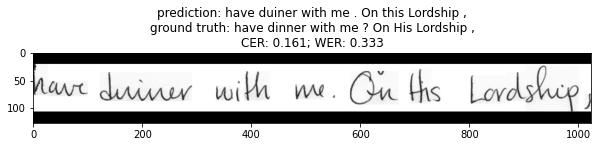

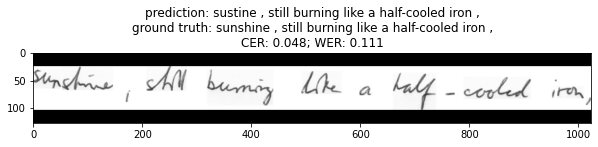

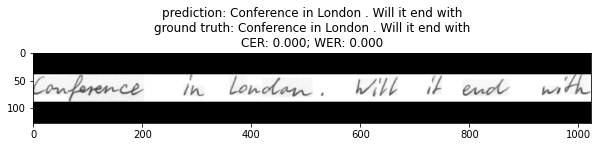

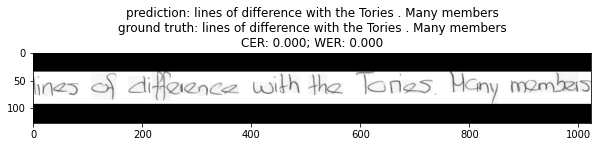

In [ ]:
#@title Результаты
from openspeech.metrics import CharacterErrorRate, WordErrorRate
CER, WER = CharacterErrorRate(tokenizer), WordErrorRate(tokenizer)

images, targets, _, _ = next(iter(val_dataloader))
images = images.to(DEVICE)

recognition_model.eval()
with torch.no_grad():

    prediction = recognition_model(images, teacher_forcing_ratio=0.0)

predicted_tokens = prediction.argmax(2).cpu()
predicted_texts = tokenizer.decode(predicted_tokens)
ground_truth_texts = tokenizer.decode(targets[:, 1:])

for i, img in enumerate(images.cpu()):
    img = img.permute(1, 2, 0)
    plt.figure(figsize=(10, 15))
    plt.imshow(img)
    dist, length = CER.metric(ground_truth_texts[i], predicted_texts[i])
    cer = dist / length
    dist, length = WER.metric(ground_truth_texts[i], predicted_texts[i])
    wer = dist / length
    plt.title('prediction: ' + predicted_texts[i] + '\n' +\
              'ground truth: ' + ground_truth_texts[i] + '\n' +\
              'CER: ' + f'{cer:.3f}' + '; WER: ' + f'{wer:.3f}')

### Добавим beam search

In [ ]:
#@markdown Поправим функции для работы с ГПУ
import torch
import torch.nn as nn

from openspeech.decoders import LSTMAttentionDecoder


class OpenspeechBeamSearchBase(nn.Module):
    """
    Openspeech's beam-search base class. Implement the methods required for beamsearch.
    You have to implement `forward` method.

    Note:
        Do not use this class directly, use one of the sub classes.
    """
    def __init__(self, decoder, beam_size: int, device):
        super(OpenspeechBeamSearchBase, self).__init__()
        self.decoder = decoder
        self.beam_size = beam_size
        self.device = device
        self.sos_id = decoder.sos_id
        self.pad_id = decoder.pad_id
        self.eos_id = decoder.eos_id
        self.ongoing_beams = None
        self.cumulative_ps = None
        self.forward_step = decoder.forward_step

    def _inflate(self, tensor: torch.Tensor, n_repeat: int, dim: int) -> torch.Tensor:
        repeat_dims = [1] * len(tensor.size())
        repeat_dims[dim] *= n_repeat
        return tensor.repeat(*repeat_dims)

    def _get_successor(
            self,
            current_ps: torch.Tensor,
            current_vs: torch.Tensor,
            finished_ids: tuple,
            num_successor: int,
            eos_count: int,
            k: int
    ) -> int:
        finished_batch_idx, finished_idx = finished_ids

        successor_ids = current_ps.topk(k + num_successor)[1]
        successor_idx = successor_ids[finished_batch_idx, -1]

        successor_p = current_ps[finished_batch_idx, successor_idx]
        successor_v = current_vs[finished_batch_idx, successor_idx].to(self.device)

        prev_status_idx = (successor_idx // k)
        prev_status = self.ongoing_beams[finished_batch_idx, prev_status_idx]
        prev_status = prev_status.view(-1)[:-1].to(self.device)

        successor = torch.cat([prev_status, successor_v.view(1)])

        if int(successor_v) == self.eos_id:
            self.finished[finished_batch_idx].append(successor)
            self.finished_ps[finished_batch_idx].append(successor_p)
            eos_count = self._get_successor(
                current_ps=current_ps,
                current_vs=current_vs,
                finished_ids=finished_ids,
                num_successor=num_successor + eos_count,
                eos_count=eos_count + 1,
                k=k,
            )

        else:
            self.ongoing_beams[finished_batch_idx, finished_idx] = successor
            self.cumulative_ps[finished_batch_idx, finished_idx] = successor_p

        return eos_count

    def _get_hypothesis(self):
        predictions = list()

        for batch_idx, batch in enumerate(self.finished):
            # if there is no terminated sentences, bring ongoing sentence which has the highest probability instead
            if len(batch) == 0:
                prob_batch = self.cumulative_ps[batch_idx]
                top_beam_idx = int(prob_batch.topk(1)[1])
                predictions.append(self.ongoing_beams[batch_idx, top_beam_idx])

            # bring highest probability sentence
            else:
                top_beam_idx = int(torch.FloatTensor(self.finished_ps[batch_idx]).topk(1)[1])
                predictions.append(self.finished[batch_idx][top_beam_idx])

        predictions = self._fill_sequence(predictions)
        return predictions

    def _is_all_finished(self, k: int) -> bool:
        for done in self.finished:
            if len(done) < k:
                return False

        return True

    def _fill_sequence(self, y_hats: list) -> torch.Tensor:
        batch_size = len(y_hats)
        max_length = -1

        for y_hat in y_hats:
            if len(y_hat) > max_length:
                max_length = len(y_hat)

        matched = torch.zeros((batch_size, max_length), dtype=torch.long)

        for batch_idx, y_hat in enumerate(y_hats):
            matched[batch_idx, :len(y_hat)] = y_hat
            matched[batch_idx, len(y_hat):] = int(self.pad_id)

        return matched

    def forward(self, *args, **kwargs):
        raise NotImplementedError


class BeamSearchLSTM(OpenspeechBeamSearchBase):
    r"""
    LSTM Beam Search Decoder

    Args: decoder, beam_size, batch_size
        decoder (DecoderLSTM): base decoder of lstm model.
        beam_size (int): size of beam.

    Inputs: encoder_outputs, targets, encoder_output_lengths, teacher_forcing_ratio
        encoder_outputs (torch.FloatTensor): A output sequence of encoders. `FloatTensor` of size ``(batch, seq_length, dimension)``
        targets (torch.LongTensor): A target sequence passed to decoders. `IntTensor` of size ``(batch, seq_length)``
        encoder_output_lengths (torch.LongTensor): A encoder output lengths sequence. `LongTensor` of size ``(batch)``
        teacher_forcing_ratio (float): Ratio of teacher forcing.

    Returns:
        * logits (torch.FloatTensor): Log probability of model predictions.
    """
    def __init__(self, decoder: LSTMAttentionDecoder, beam_size: int, device):
        super(BeamSearchLSTM, self).__init__(decoder, beam_size, device)
        self.hidden_state_dim = decoder.hidden_state_dim
        self.num_layers = decoder.num_layers
        self.validate_args = decoder.validate_args

    def forward(
            self,
            encoder_outputs: torch.Tensor,
            encoder_output_lengths: torch.Tensor,
    ) -> torch.Tensor:
        r"""
        Beam search decoding.

        Inputs: encoder_outputs
            encoder_outputs (torch.FloatTensor): A output sequence of encoders. `FloatTensor` of size ``(batch, seq_length, dimension)``

        Returns:
            * logits (torch.FloatTensor): Log probability of model predictions.
        """
        batch_size, hidden_states = encoder_outputs.size(0), None

        self.finished = [[] for _ in range(batch_size)]
        self.finished_ps = [[] for _ in range(batch_size)]

        inputs, batch_size, max_length = self.validate_args(None, encoder_outputs, teacher_forcing_ratio=0.0)

        step_outputs, hidden_states, attn = self.forward_step(inputs, hidden_states, encoder_outputs)
        self.cumulative_ps, self.ongoing_beams = step_outputs.topk(self.beam_size)

        self.ongoing_beams = self.ongoing_beams.view(batch_size * self.beam_size, 1)
        self.cumulative_ps = self.cumulative_ps.view(batch_size * self.beam_size, 1)

        input_var = self.ongoing_beams

        encoder_dim = encoder_outputs.size(2)
        encoder_outputs = self._inflate(encoder_outputs, self.beam_size, dim=0)
        encoder_outputs = encoder_outputs.view(self.beam_size, batch_size, -1, encoder_dim)
        encoder_outputs = encoder_outputs.transpose(0, 1)
        encoder_outputs = encoder_outputs.reshape(batch_size * self.beam_size, -1, encoder_dim)

        if attn is not None:
            attn = self._inflate(attn, self.beam_size, dim=0)

        if isinstance(hidden_states, tuple):
            hidden_states = tuple([self._inflate(h, self.beam_size, 1) for h in hidden_states])
        else:
            hidden_states = self._inflate(hidden_states, self.beam_size, 1)

        for di in range(max_length - 1):
            if self._is_all_finished(self.beam_size):
                break

            if isinstance(hidden_states, tuple):
                tuple(h.view(self.num_layers, batch_size * self.beam_size, self.hidden_state_dim) for h in hidden_states)
            else:
                hidden_states = hidden_states.view(self.num_layers, batch_size * self.beam_size, self.hidden_state_dim)
            step_outputs, hidden_states, attn = self.forward_step(input_var, hidden_states, encoder_outputs, attn)

            step_outputs = step_outputs.view(batch_size, self.beam_size, -1)
            current_ps, current_vs = step_outputs.topk(self.beam_size)

            self.cumulative_ps = self.cumulative_ps.view(batch_size, self.beam_size)
            self.ongoing_beams = self.ongoing_beams.view(batch_size, self.beam_size, -1)

            current_ps = (current_ps.permute(0, 2, 1) + self.cumulative_ps.unsqueeze(1)).permute(0, 2, 1)
            current_ps = current_ps.view(batch_size, self.beam_size ** 2)
            current_vs = current_vs.view(batch_size, self.beam_size ** 2)

            self.cumulative_ps = self.cumulative_ps.view(batch_size, self.beam_size)
            self.ongoing_beams = self.ongoing_beams.view(batch_size, self.beam_size, -1)

            topk_current_ps, topk_status_ids = current_ps.topk(self.beam_size)
            prev_status_ids = (topk_status_ids // self.beam_size)

            topk_current_vs = torch.zeros((batch_size, self.beam_size), dtype=torch.long)
            prev_status = torch.zeros(self.ongoing_beams.size(), dtype=torch.long)

            for batch_idx, batch in enumerate(topk_status_ids):
                for idx, topk_status_idx in enumerate(batch):
                    topk_current_vs[batch_idx, idx] = current_vs[batch_idx, topk_status_idx]
                    prev_status[batch_idx, idx] = self.ongoing_beams[batch_idx, prev_status_ids[batch_idx, idx]]

            self.ongoing_beams = torch.cat([prev_status, topk_current_vs.unsqueeze(2)], dim=2)
            self.cumulative_ps = topk_current_ps

            if torch.any(topk_current_vs == self.eos_id):
                finished_ids = torch.where(topk_current_vs == self.eos_id)
                num_successors = [1] * batch_size

                for (batch_idx, idx) in zip(*finished_ids):
                    self.finished[batch_idx].append(self.ongoing_beams[batch_idx, idx])
                    self.finished_ps[batch_idx].append(self.cumulative_ps[batch_idx, idx])

                    if self.beam_size != 1:
                        eos_count = self._get_successor(
                            current_ps=current_ps,
                            current_vs=current_vs,
                            finished_ids=(batch_idx, idx),
                            num_successor=num_successors[batch_idx],
                            eos_count=1,
                            k=self.beam_size,
                        )
                        num_successors[batch_idx] += eos_count

            input_var = self.ongoing_beams[:, :, -1]
            input_var = input_var.view(batch_size * self.beam_size, -1).to(self.device)

        return self._get_hypothesis()

In [ ]:
# Создадим BeamSearchDecoder
recognition_model.beam_search = BeamSearchLSTM(
    recognition_model.decoder, beam_size=3, device=DEVICE)

In [ ]:
#@title Валидация с BeamSearch 
#@markdown > Сам по себе BS портит скор...
def evaluate_beam(model, val_dataloader):
    model.eval()
    losses = 0
    cers = 0
    wers = 0

    with torch.no_grad():
        with tqdm(total=len(val_dataloader)) as pbar:
            for img, tgt, img_len, tgt_len in val_dataloader:
                img = img.to(DEVICE)
                tgt = tgt.to(DEVICE)
                # tgt_len = tgt_len.to(DEVICE)

                encoder_output = recognition_model.encode(img)
                output_len = torch.tensor(BATCH_SIZE*[encoder_output.shape[1]], device=DEVICE)
                prediction = recognition_model.beam_search(encoder_output, output_len)

                predicted_texts = [tokenizer.decode(i[i != 0]) for i in prediction]
                ground_truth_texts = tokenizer.decode(tgt[:, 1:])

                metrics = [CER.metric(ground_truth_texts[i], predicted_texts[i]) for i in range(BATCH_SIZE)]
                cer = sum([dist / length for dist, length in metrics]) / len(metrics)
                metrics = [WER.metric(ground_truth_texts[i], predicted_texts[i]) for i in range(BATCH_SIZE)]
                wer = sum([dist / length for dist, length in metrics]) / len(metrics)

                cers += cer
                wers += wer

                pbar.set_description(f'CER: {cer:.2f}, WER: {wer:.2f}')
                pbar.update(1)


    return cers / len(val_dataloader), wers / len(val_dataloader)

cer, wer = evaluate_beam(recognition_model, val_dataloader)
print(f'CER: {cer}; WER: {wer}')

  0%|          | 0/389 [00:00<?, ?it/s]

CER: 0.17498885512722198; WER: 0.37777664446630865


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


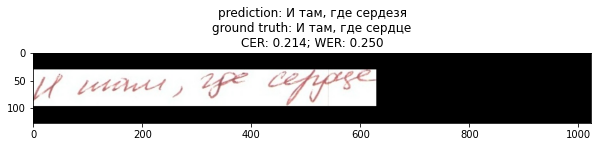

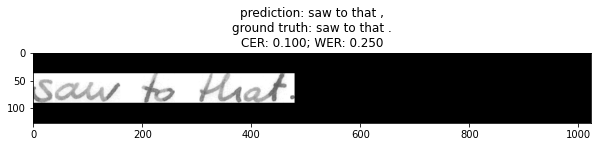

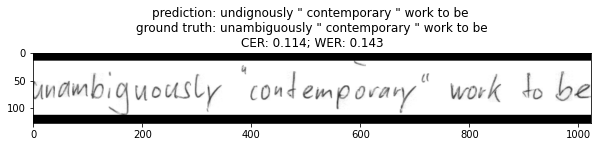

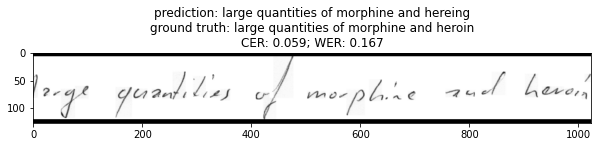

In [ ]:
#@title Результаты
images, targets, _, _ = next(iter(val_dataloader))
images = images.to(DEVICE)

recognition_model.eval()
with torch.no_grad():

    encoder_output = recognition_model.encode(images)
    output_len = torch.tensor(BATCH_SIZE*[encoder_output.shape[1]], device=DEVICE)
    prediction = recognition_model.beam_search(encoder_output, output_len)

predicted_texts = [tokenizer.decode(i[i != 0]) for i in prediction]
ground_truth_texts = tokenizer.decode(targets[:, 1:])

for i, img in enumerate(images.cpu()):
    img = img.permute(1, 2, 0)
    plt.figure(figsize=(10, 15))
    plt.imshow(img)
    dist, length = CER.metric(ground_truth_texts[i], predicted_texts[i])
    cer = dist / length
    dist, length = WER.metric(ground_truth_texts[i], predicted_texts[i])
    wer = dist / length
    plt.title('prediction: ' + predicted_texts[i] + '\n' +\
              'ground truth: ' + ground_truth_texts[i] + '\n' +\
              'CER: ' + f'{cer:.3f}' + '; WER: ' + f'{wer:.3f}')

### Обучим лингвистическую модель

In [ ]:
with open('lm.txt', 'w') as f:
    for line in all_data.text.values:
        f.write(line + '\n')

In [ ]:
with open('labels.txt', 'w') as f:
    for char in char2int.keys():
        f.write(char + '\n')

In [ ]:
!python ./openspeech/openspeech_cli/hydra_lm_train.py \
    dataset=lm \
    dataset.dataset_path=./lm.txt \
    tokenizer=kspon_character \
    tokenizer.vocab_path=./vocab.csv \
    model=lstm_lm \
    lr_scheduler=tri_stage \
    trainer=gpu \
    criterion=perplexity

In [ ]:
#@markdown LM Config
dictLMConfig = OmegaConf.create('''dataset:
  dataset: lm
  dataset_path: ./lm.txt
  valid_ratio: 0.05
  test_ratio: 0.05
criterion:
  criterion_name: perplexity
  reduction: mean
lr_scheduler:
  lr: 0.0001
  scheduler_name: tri_stage
  init_lr: 1.0e-07
  init_lr_scale: 0.01
  final_lr_scale: 0.01
  phase_ratio: (0.1, 0.4, 0.5)
  total_steps: 400000
model:
  model_name: lstm_lm
  num_layers: 3
  hidden_state_dim: 512
  dropout_p: 0.3
  rnn_type: lstm
  max_length: 128
  teacher_forcing_ratio: 1.0
  optimizer: adam
trainer:
  seed: 1
  accelerator: dp
  accumulate_grad_batches: 1
  num_workers: 4
  batch_size: 32
  check_val_every_n_epoch: 1
  gradient_clip_val: 5.0
  logger: wandb
  max_epochs: 20
  save_checkpoint_n_steps: 10000
  auto_scale_batch_size: binsearch
  sampler: smart
  name: gpu
  device: gpu
  use_cuda: true
  auto_select_gpus: true
tokenizer:
  sos_token: '[sos]'
  eos_token: '[eos]'
  pad_token: '[pad]'
  blank_token: '[blk]'
  encoding: utf-8
  unit: kspon_character
  vocab_path: ./vocab.csv''')

In [ ]:
#@markdown Код для обучения
import os
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.utilities import rank_zero_info

from openspeech.dataclass.initialize import hydra_lm_train_init
from openspeech.datasets import DATA_MODULE_REGISTRY
from openspeech.models import MODEL_REGISTRY
from openspeech.utils import parse_configs, get_pl_trainer


@hydra.main(config_path=os.path.join("..", "openspeech", "configs"), config_name="lm_train")
def hydra_main(configs: DictConfig) -> None:
    rank_zero_info(OmegaConf.to_yaml(configs))
    pl.seed_everything(configs.trainer.seed)

    logger, num_devices = parse_configs(configs)

    data_module = DATA_MODULE_REGISTRY[configs.dataset.dataset](configs)
    tokenizer = data_module.prepare_data()
    data_module.setup(tokenizer=tokenizer)

    model = MODEL_REGISTRY[configs.model.model_name](configs=configs, tokenizer=tokenizer)
    model.build_model()

    trainer = get_pl_trainer(configs, num_devices, logger)
    trainer.fit(model, data_module)
    trainer.test()


if __name__ == '__main__':
    hydra_lm_train_init()
    hydra_main(dictLMConfig)

# Инференс

In [ ]:
#@markdown Клонируем openspeech репо
#@markdown - https://github.com/openspeech-team/openspeech
# Установка пререквизитов
print('Установка...')
!pip install -q pybind11
!pip install -q warp-rnnt
!pip install -q --upgrade albumentations
# Клонируем репо
!git clone https://github.com/openspeech-team/openspeech.git &> /dev/null
%cd openspeech
# Устанавливаем. Через pip не устанавливается нормально :(
!chmod +x ./install.sh
!./install.sh &> /dev/null
%cd ..
# Добавляем в path, где python ищет модули
import sys
sys.path.append('/content/openspeech')
# Скачать словарь
!gdown https://drive.google.com/uc?id=1xNpIOrQZgnyTfa-8yjsiVaiTyL-mLshK
# Функция для разметки
!rm -r utils
!mkdir utils
%cd utils
!wget https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/utils/colab_utils.py &> /dev/null
%cd .. 

Установка...
     |████████████████████████████████| 200 kB 12.4 MB/s 


In [ ]:
#@markdown Импорт библиотек, определение гиперпараметров
import pandas as pd
import numpy as np
import torch
import torchvision
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.models as models
import json
import glob
import math
import cv2
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline

def resize_if_need(img, max_h, max_w):
    img_h, img_w, img_c = img.shape
    coef = 1 if img_h <= max_h and img_w <= max_w else max(img_h / max_h, img_w / max_w)
    h = int(img_h / coef)
    w = int(img_w / coef)
    img = cv2.resize(img, (w, h))
    return img

def make_img_padding_right(image, max_h, max_w):
    img = image.copy()
    img_h, img_w, img_c = img.shape
    bg = np.zeros((max_h, max_w, img_c), dtype=np.uint8)
    x1 = 0  # (max_w - img_w) // 2
    y1 = (max_h - img_h) // 2
    x2 = x1 + img_w
    y2 = y1 + img_h
    bg[y1:y2, x1:x2, :] = img.copy()
    return bg

# Создание конфига для словаря
from omegaconf import OmegaConf
from openspeech.tokenizers.librispeech.character import LibriSpeechCharacterTokenizer

dictConfig = OmegaConf.create({
    'tokenizer': {
        'pad_token': '[pad]',
        'sos_token': '[sos]',
        'eos_token': '[eos]',
        'blank_token': '[blk]',
        'vocab_path': 'vocab.csv',
        'encoding': 'utf-8'
    }
})

tokenizer = LibriSpeechCharacterTokenizer(dictConfig)

# Гиперпараметры модели
IMAGE_H = 128 #@param {type:"integer"}
IMAGE_W = 1024 #@param {type:"integer"}
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
VAL_SIZE = 0.1
BATCH_SIZE = 4
OCR_MODEL_PARAMS = {
    'time_feature_count': 256,
    'lstm_hidden': 256,
    'lstm_len': 3,
    'n_class': len(tokenizer.labels),
    'pad_id': tokenizer.pad_id,
    'sos_id': tokenizer.sos_id,
    'eos_id': tokenizer.eos_id,
}

In [ ]:
#@markdown Поправим функции для работы с ГПУ
import torch
import torch.nn as nn

from openspeech.decoders import LSTMAttentionDecoder


class OpenspeechBeamSearchBase(nn.Module):
    """
    Openspeech's beam-search base class. Implement the methods required for beamsearch.
    You have to implement `forward` method.

    Note:
        Do not use this class directly, use one of the sub classes.
    """
    def __init__(self, decoder, beam_size: int, device):
        super(OpenspeechBeamSearchBase, self).__init__()
        self.decoder = decoder
        self.beam_size = beam_size
        self.device = device
        self.sos_id = decoder.sos_id
        self.pad_id = decoder.pad_id
        self.eos_id = decoder.eos_id
        self.ongoing_beams = None
        self.cumulative_ps = None
        self.forward_step = decoder.forward_step

    def _inflate(self, tensor: torch.Tensor, n_repeat: int, dim: int) -> torch.Tensor:
        repeat_dims = [1] * len(tensor.size())
        repeat_dims[dim] *= n_repeat
        return tensor.repeat(*repeat_dims)

    def _get_successor(
            self,
            current_ps: torch.Tensor,
            current_vs: torch.Tensor,
            finished_ids: tuple,
            num_successor: int,
            eos_count: int,
            k: int
    ) -> int:
        finished_batch_idx, finished_idx = finished_ids

        successor_ids = current_ps.topk(k + num_successor)[1]
        successor_idx = successor_ids[finished_batch_idx, -1]

        successor_p = current_ps[finished_batch_idx, successor_idx]
        successor_v = current_vs[finished_batch_idx, successor_idx].to(self.device)

        prev_status_idx = (successor_idx // k)
        prev_status = self.ongoing_beams[finished_batch_idx, prev_status_idx]
        prev_status = prev_status.view(-1)[:-1].to(self.device)

        successor = torch.cat([prev_status, successor_v.view(1)])

        if int(successor_v) == self.eos_id:
            self.finished[finished_batch_idx].append(successor)
            self.finished_ps[finished_batch_idx].append(successor_p)
            eos_count = self._get_successor(
                current_ps=current_ps,
                current_vs=current_vs,
                finished_ids=finished_ids,
                num_successor=num_successor + eos_count,
                eos_count=eos_count + 1,
                k=k,
            )

        else:
            self.ongoing_beams[finished_batch_idx, finished_idx] = successor
            self.cumulative_ps[finished_batch_idx, finished_idx] = successor_p

        return eos_count

    def _get_hypothesis(self):
        predictions = list()

        for batch_idx, batch in enumerate(self.finished):
            # if there is no terminated sentences, bring ongoing sentence which has the highest probability instead
            if len(batch) == 0:
                prob_batch = self.cumulative_ps[batch_idx]
                top_beam_idx = int(prob_batch.topk(1)[1])
                predictions.append(self.ongoing_beams[batch_idx, top_beam_idx])

            # bring highest probability sentence
            else:
                top_beam_idx = int(torch.FloatTensor(self.finished_ps[batch_idx]).topk(1)[1])
                predictions.append(self.finished[batch_idx][top_beam_idx])

        predictions = self._fill_sequence(predictions)
        return predictions

    def _is_all_finished(self, k: int) -> bool:
        for done in self.finished:
            if len(done) < k:
                return False

        return True

    def _fill_sequence(self, y_hats: list) -> torch.Tensor:
        batch_size = len(y_hats)
        max_length = -1

        for y_hat in y_hats:
            if len(y_hat) > max_length:
                max_length = len(y_hat)

        matched = torch.zeros((batch_size, max_length), dtype=torch.long)

        for batch_idx, y_hat in enumerate(y_hats):
            matched[batch_idx, :len(y_hat)] = y_hat
            matched[batch_idx, len(y_hat):] = int(self.pad_id)

        return matched

    def forward(self, *args, **kwargs):
        raise NotImplementedError


class BeamSearchLSTM(OpenspeechBeamSearchBase):
    r"""
    LSTM Beam Search Decoder

    Args: decoder, beam_size, batch_size
        decoder (DecoderLSTM): base decoder of lstm model.
        beam_size (int): size of beam.

    Inputs: encoder_outputs, targets, encoder_output_lengths, teacher_forcing_ratio
        encoder_outputs (torch.FloatTensor): A output sequence of encoders. `FloatTensor` of size ``(batch, seq_length, dimension)``
        targets (torch.LongTensor): A target sequence passed to decoders. `IntTensor` of size ``(batch, seq_length)``
        encoder_output_lengths (torch.LongTensor): A encoder output lengths sequence. `LongTensor` of size ``(batch)``
        teacher_forcing_ratio (float): Ratio of teacher forcing.

    Returns:
        * logits (torch.FloatTensor): Log probability of model predictions.
    """
    def __init__(self, decoder: LSTMAttentionDecoder, beam_size: int, device):
        super(BeamSearchLSTM, self).__init__(decoder, beam_size, device)
        self.hidden_state_dim = decoder.hidden_state_dim
        self.num_layers = decoder.num_layers
        self.validate_args = decoder.validate_args

    def forward(
            self,
            encoder_outputs: torch.Tensor,
            encoder_output_lengths: torch.Tensor,
    ) -> torch.Tensor:
        r"""
        Beam search decoding.

        Inputs: encoder_outputs
            encoder_outputs (torch.FloatTensor): A output sequence of encoders. `FloatTensor` of size ``(batch, seq_length, dimension)``

        Returns:
            * logits (torch.FloatTensor): Log probability of model predictions.
        """
        batch_size, hidden_states = encoder_outputs.size(0), None

        self.finished = [[] for _ in range(batch_size)]
        self.finished_ps = [[] for _ in range(batch_size)]

        inputs, batch_size, max_length = self.validate_args(None, encoder_outputs, teacher_forcing_ratio=0.0)

        step_outputs, hidden_states, attn = self.forward_step(inputs, hidden_states, encoder_outputs)
        self.cumulative_ps, self.ongoing_beams = step_outputs.topk(self.beam_size)

        self.ongoing_beams = self.ongoing_beams.view(batch_size * self.beam_size, 1)
        self.cumulative_ps = self.cumulative_ps.view(batch_size * self.beam_size, 1)

        input_var = self.ongoing_beams

        encoder_dim = encoder_outputs.size(2)
        encoder_outputs = self._inflate(encoder_outputs, self.beam_size, dim=0)
        encoder_outputs = encoder_outputs.view(self.beam_size, batch_size, -1, encoder_dim)
        encoder_outputs = encoder_outputs.transpose(0, 1)
        encoder_outputs = encoder_outputs.reshape(batch_size * self.beam_size, -1, encoder_dim)

        if attn is not None:
            attn = self._inflate(attn, self.beam_size, dim=0)

        if isinstance(hidden_states, tuple):
            hidden_states = tuple([self._inflate(h, self.beam_size, 1) for h in hidden_states])
        else:
            hidden_states = self._inflate(hidden_states, self.beam_size, 1)

        for di in range(max_length - 1):
            if self._is_all_finished(self.beam_size):
                break

            if isinstance(hidden_states, tuple):
                tuple(h.view(self.num_layers, batch_size * self.beam_size, self.hidden_state_dim) for h in hidden_states)
            else:
                hidden_states = hidden_states.view(self.num_layers, batch_size * self.beam_size, self.hidden_state_dim)
            step_outputs, hidden_states, attn = self.forward_step(input_var, hidden_states, encoder_outputs, attn)

            step_outputs = step_outputs.view(batch_size, self.beam_size, -1)
            current_ps, current_vs = step_outputs.topk(self.beam_size)

            self.cumulative_ps = self.cumulative_ps.view(batch_size, self.beam_size)
            self.ongoing_beams = self.ongoing_beams.view(batch_size, self.beam_size, -1)

            current_ps = (current_ps.permute(0, 2, 1) + self.cumulative_ps.unsqueeze(1)).permute(0, 2, 1)
            current_ps = current_ps.view(batch_size, self.beam_size ** 2)
            current_vs = current_vs.view(batch_size, self.beam_size ** 2)

            self.cumulative_ps = self.cumulative_ps.view(batch_size, self.beam_size)
            self.ongoing_beams = self.ongoing_beams.view(batch_size, self.beam_size, -1)

            topk_current_ps, topk_status_ids = current_ps.topk(self.beam_size)
            prev_status_ids = (topk_status_ids // self.beam_size)

            topk_current_vs = torch.zeros((batch_size, self.beam_size), dtype=torch.long)
            prev_status = torch.zeros(self.ongoing_beams.size(), dtype=torch.long)

            for batch_idx, batch in enumerate(topk_status_ids):
                for idx, topk_status_idx in enumerate(batch):
                    topk_current_vs[batch_idx, idx] = current_vs[batch_idx, topk_status_idx]
                    prev_status[batch_idx, idx] = self.ongoing_beams[batch_idx, prev_status_ids[batch_idx, idx]]

            self.ongoing_beams = torch.cat([prev_status, topk_current_vs.unsqueeze(2)], dim=2)
            self.cumulative_ps = topk_current_ps

            if torch.any(topk_current_vs == self.eos_id):
                finished_ids = torch.where(topk_current_vs == self.eos_id)
                num_successors = [1] * batch_size

                for (batch_idx, idx) in zip(*finished_ids):
                    self.finished[batch_idx].append(self.ongoing_beams[batch_idx, idx])
                    self.finished_ps[batch_idx].append(self.cumulative_ps[batch_idx, idx])

                    if self.beam_size != 1:
                        eos_count = self._get_successor(
                            current_ps=current_ps,
                            current_vs=current_vs,
                            finished_ids=(batch_idx, idx),
                            num_successor=num_successors[batch_idx],
                            eos_count=1,
                            k=self.beam_size,
                        )
                        num_successors[batch_idx] += eos_count

            input_var = self.ongoing_beams[:, :, -1]
            input_var = input_var.view(batch_size * self.beam_size, -1).to(self.device)

        return self._get_hypothesis()

In [ ]:
#@title Baseline model
from openspeech.decoders.lstm_attention_decoder import LSTMAttentionDecoder

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out


class RecognitionModel(nn.Module):
    def __init__(self,
                 feature_extractor,
                 time_feature_count, 
                 lstm_hidden,
                 lstm_len,
                 n_class,
                 pad_id,
                 sos_id,
                 eos_id):
        super(RecognitionModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.avg_pool = nn.AdaptiveAvgPool2d((time_feature_count, time_feature_count))
        self.bilstm = BiLSTM(time_feature_count, lstm_hidden, lstm_len)
        self.decoder = LSTMAttentionDecoder(
            num_classes=n_class, 
            max_length=time_feature_count,
            hidden_state_dim=lstm_hidden * 2,
            pad_id=pad_id, sos_id=sos_id,
            eos_id=eos_id,
            attn_mechanism='multi-head',
            num_heads=4,
            num_layers=2,
            rnn_type='lstm',
            dropout_p=0.3
        )

    def forward(self, x, targets=None, teacher_forcing_ratio=1.0):
        x = self.encode(x)
        x_len = x.shape[1]
        x = self.decoder(x, targets, x_len, teacher_forcing_ratio)
        return x
    
    def encode(self, x):
        x = self.feature_extractor(x)
        b, c, h, w = x.size()
        x = x.view(b, c * h, w)
        x = self.avg_pool(x)
        feat = x.transpose(1, 2)
        x = self.bilstm(feat) # (N, L, D * H)
        return x
    
    def decode(self, x, x_len, targets=None, teacher_forcing_ratio=1.0):
        x = self.decoder(x, targets, x_len, teacher_forcing_ratio)
        return x


def get_resnet_backbone(pretrained=True):
    m = models.resnet34(pretrained=pretrained)
    input_conv = nn.Conv2d(3, 64, 7, 1, 3)
    blocks = [input_conv, m.bn1, m.relu, m.maxpool, m.layer1, m.layer2, m.layer3]
    return nn.Sequential(*blocks)

def get_resnet34_model(pretrained=True):
    backbone = get_resnet_backbone(pretrained)
    model = RecognitionModel(backbone, **OCR_MODEL_PARAMS)
    model = model.to(DEVICE)
    return model


recognition_model = get_resnet34_model(False)
# Создадим BeamSearchDecoder
recognition_model.beam_search = BeamSearchLSTM(
    recognition_model.decoder, beam_size=3, device=DEVICE)

# Загрузка весов 
# 18 эпох
!gdown https://drive.google.com/uc?id=1-QE71DVX-w7rs2hdQaAsWWMOAoz_H3Nc
# 17 эпох
# !gdown https://drive.google.com/uc?id=1-LTdwXzjAYM11nSrGX4hFyhsEJKlLFd0
# 14 эпох
# !gdown https://drive.google.com/uc?id=1-2Yv7Iip-LnzQQYvtYiSAyadmwgV18LX
# !gdown https://drive.google.com/uc?id=1-59R1feu1-pLZmO5LQFol_HHABwppjmQ
# !gdown https://drive.google.com/uc?id=1-71-3fF0CcPEjBJsh1gaZlgsylW1FOtu
recognition_model.load_state_dict(torch.load(f'/content/baseline_tf_e{18}.pt'), strict=False)

Downloading...
From: https://drive.google.com/uc?id=1-2Yv7Iip-LnzQQYvtYiSAyadmwgV18LX
To: /content/baseline_tf_e14.pt
72.3MB [00:00, 94.5MB/s]


_IncompatibleKeys(missing_keys=['beam_search.decoder.embedding.weight', 'beam_search.decoder.rnn.weight_ih_l0', 'beam_search.decoder.rnn.weight_hh_l0', 'beam_search.decoder.rnn.bias_ih_l0', 'beam_search.decoder.rnn.bias_hh_l0', 'beam_search.decoder.rnn.weight_ih_l1', 'beam_search.decoder.rnn.weight_hh_l1', 'beam_search.decoder.rnn.bias_ih_l1', 'beam_search.decoder.rnn.bias_hh_l1', 'beam_search.decoder.attention.query_proj.linear.weight', 'beam_search.decoder.attention.query_proj.linear.bias', 'beam_search.decoder.attention.key_proj.linear.weight', 'beam_search.decoder.attention.key_proj.linear.bias', 'beam_search.decoder.attention.value_proj.linear.weight', 'beam_search.decoder.attention.value_proj.linear.bias', 'beam_search.decoder.fc.0.linear.weight', 'beam_search.decoder.fc.0.linear.bias', 'beam_search.decoder.fc.3.linear.weight', 'beam_search.decoder.fc.3.linear.bias'], unexpected_keys=[])

In [ ]:
#@markdown Загрузить тестовую картинку
#@markdown > Также можно загрузить свои картинки, если поставить галочку в ```upload_own```
from google.colab import files

upload_own = False #@param {type:"boolean"}

!rm -r test_images
!mkdir test_images
%cd test_images
!gdown https://drive.google.com/uc?id=1vPeymad_LwLNakbohcO1aVcxEPJ8uxsP
if upload_own:
    uploaded = files.upload()
%cd ..

rm: cannot remove 'test_images': No such file or directory
/content/test_images
Downloading...
From: https://drive.google.com/uc?id=1vPeymad_LwLNakbohcO1aVcxEPJ8uxsP
To: /content/test_images/test_image.jpg
100% 138k/138k [00:00<00:00, 49.5MB/s]
/content


In [ ]:
#@markdown ### Разметить картинки
#@markdown > К сожалению, задачу сегментации (детекции) текста мы не решали 
#@markdown 
#@markdown Обведите, пожалуйста, тексты в рамки (по 1-ой на каждую строку)
#@markdown  и нажмите ```submit``` для каждой картинки
from utils import colab_utils
import glob

test_images = []
image_filenames = glob.glob('./test_images/*')
for f_name in image_filenames:
    test_images.append(cv2.cvtColor(cv2.imread(f_name), cv2.COLOR_BGR2RGB))

gt_boxes = []
colab_utils.annotate(test_images, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
# Если не хочется самому размечать bbox'ы для референсной картинки
# gt_boxes = [np.array([
#            [0.462     , 0.286875  , 0.59533333, 0.63875   ],
#            [0.28866666, 0.534125  , 0.38033333, 0.894125  ],
#            [0.592     , 0.091875  , 0.72533333, 0.59      ]])]

In [ ]:
#@markdown Предварительная обработка картинок
def save_text_lines(images, gt_boxes):
    !rm -r textlines
    !mkdir textlines
    textlines = []
    for i, image in enumerate(gt_boxes):
        for j, text_line in enumerate(image):
            x1, y1, x2, y2 = text_line.tolist()
            h, w, c = images[i].shape
            x1, y1, x2, y2 = int(h * x1), int(w * y1), int(h * x2), int(w * y2)
            image_with_text = images[i][x1:x2, y1:y2 ,:]
            plt.imsave(f'textlines/{i}_{j}.jpg', image_with_text)
            image_with_text = resize_if_need(image_with_text, IMAGE_H, IMAGE_W)
            image_with_text = make_img_padding_right(image_with_text, IMAGE_H, IMAGE_W)
            image_with_text = image_with_text.astype(np.float32) / 255.0
            image_with_text = torch.from_numpy(image_with_text).permute(2, 0, 1).unsqueeze(0)
            textlines.append(image_with_text)
    
    return textlines

textlines = save_text_lines(test_images, gt_boxes)

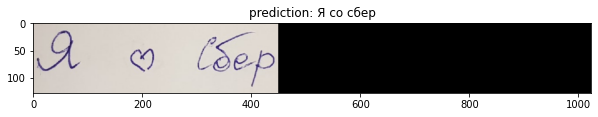

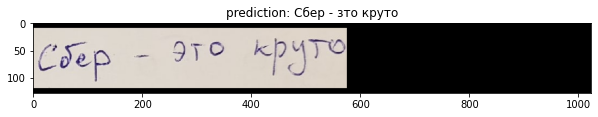

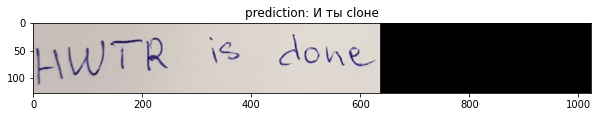

In [ ]:
#@title Результат

use_beam_search = False #@param {type:"boolean"}

recognition_model.eval()
for textline in textlines:

    with torch.no_grad():

        if use_beam_search:
            encoder_output = recognition_model.encode(textline.to(DEVICE))
            output_len = torch.tensor(BATCH_SIZE*[encoder_output.shape[1]], device=DEVICE)
            prediction = recognition_model.beam_search(encoder_output, output_len)
            predicted_texts = [tokenizer.decode(i[i != 0]) for i in prediction]
        else:
            prediction = recognition_model(textline.to(DEVICE), teacher_forcing_ratio=0.0)
            predicted_tokens = prediction.argmax(2).cpu()
            predicted_texts = tokenizer.decode(predicted_tokens)

    for i, img in enumerate(textline.cpu()):
        img = img.permute(1, 2, 0)
        plt.figure(figsize=(10, 15))
        plt.imshow(img)
        plt.title('prediction: ' + predicted_texts[i])